# Time Series Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import math
import os

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset

In [2]:
# df_raw_owid = pd.read_csv('dataset/owid/owid-co2-data.csv')
# df_raw_ghg = pd.read_csv('dataset/owid/ghg-emissions-by-sector.csv')
# df_worldbank_meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')
df_worldbank_imputed = pd.read_csv('output/dataset_worldbank_imputed.csv')
df_raw_worldbank = pd.read_csv('dataset/worldbank/API.csv')
df_raw_worldbank_transposed = pd.read_csv('output/dataset_worldbank_transposed.csv')

## README
(Last Update: 4 / March / 2022)

This is the overall content of this notebook.

### EDA

EDA for imputed dataset, nothing fancy.

### Clustering Preprocessing

The preprocessing steps start with some basics filtering
1. filter country name
2. filter years range

The dataset imported (`df_worldbank_imputed`) are cleaned and imputed already. This preprocessing stage are to
1. Performa data normalization
2. Pivot dataset into another **year-column** format (columns of years)
3. Lastly, prepare X_train dataset (tslearn needs to use `to_time_series_dataset` to preprocess data)


### Time Series K Means

There are 3 ways of K means clustering, listed below
- Euclidean K Means
- DBA K Means
- Soft DTW K Means

Each of this clustering method is being made into a function. The function will plot a graph for clustering result and return y_pred clustering results. 

A silhouette score is conducted as well to find the optimal number of k and optimal clustering algorithm to use.

For the time being, `dba k means` is being used. Learn more about their difference at this [medium](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3) post. 

### EDA for Clustering Results

Lastly, after obtaining clustering results, this part serves the purpose of listing country name in clustering result or plot more detailed graph. 

Use `get_df_viz` to get cluster result, and plotly to plot the graph.

## Basic EDA
For imputed dataset, nothing fancy

In [3]:
df_worldbank_imputed

Country Name  Year  CO2 emissions (metric tons per capita)  \
0            Aruba  1980                              174.694594   
1            Aruba  1981                              165.121266   
2            Aruba  1982                              182.270961   
3            Aruba  1983                               92.363156   
4            Aruba  1984                              228.392242   
...            ...   ...                                     ...   
10450     Zimbabwe  2016                                0.783303   
10451     Zimbabwe  2017                                0.718570   
10452     Zimbabwe  2018                                0.849793   
10453     Zimbabwe  2019                                1.044350   
10454     Zimbabwe  2020                                1.009967   

       CO2 emissions (kt)  Urban population (% of total population)  \
0            10498.621000                                    50.472   
1             9999.909000                                    50.456   
2            11180.683000                                    50.441   
3             5746.189000                                    50.426   
4            14348.971000                                    50.411   
...                   ...                                       ...   
10450        10990.000000                                    32.296   
10451        10230.000000                                    32.237   
10452        12270.000000                                    32.209   
10453        22202.653263                                    32.210   
10454        22207.153892                                    32.242   

       Population growth (annual %)  \
0                          0.208214   
1                          0.769120   
2                          1.279734   
3                          1.411552   
4                          0.980502   
...                             ...   
10450                      1.549294   
10451                      1.459406   
10452                      1.410382   
10453                      1.421142   
10454                      1.473871   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
0                                             424.783771       
1                                             519.001013       
2                                             564.023574       
3                                             530.385687       
4                                             571.038292       
...                                                  ...       
10450                                       29120.000000       
10451                                       28800.000000       
10452                                       31380.000000       
10453                                       83902.692361       
10454                                       83894.818702       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
0                                             114.675152                                           
1                                             191.589042                                           
2                                             204.145519                                           
3                                             239.228605                                           
4                                             246.726780                                           
...                                                  ...                                           
10450                                        1587.372070                                           
10451                                        1266.889816                                           
10452                                        1394.553693                                           
10453                                       23047.297738                                          

In [4]:
df_worldbank_imputed.describe()

Year  CO2 emissions (metric tons per capita)  \
count  10455.000000                            10455.000000   
mean    2000.000000                                4.324454   
std       11.832725                                6.774820   
min     1980.000000                                0.000000   
25%     1990.000000                                0.749236   
50%     2000.000000                                2.627933   
75%     2010.000000                                5.985056   
max     2020.000000                              266.483562   

       CO2 emissions (kt)  Urban population (% of total population)  \
count        1.045500e+04                              10455.000000   
mean         8.473830e+05                                 53.516498   
std          2.917141e+06                                 23.428964   
min          0.000000e+00                                  4.339000   
25%          2.240000e+03                                 33.786500   
50%          2.432727e+04                                 52.824000   
75%          1.575450e+05                                 72.615888   
max          3.404105e+07                                100.000000   

       Population growth (annual %)  \
count                  10455.000000   
mean                       1.602138   
std                        1.405863   
min                       -6.766133   
25%                        0.616634   
50%                        1.530234   
75%                        2.540373   
max                       17.512207   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                       1.045500e+04       
mean                                        1.270182e+06       
std                                         4.072949e+06       
min                                         0.000000e+00       
25%                                         1.233000e+04       
50%                                         6.743000e+04       
75%                                         2.812050e+05       
max                                         4.587385e+07       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                       1.045500e+04                                           
mean                                        3.816025e+04                                           
std                                         3.734250e+05                                           
min                                        -1.064283e+06                                           
25%                                        -1.610261e+03                                           
50%                                         3.585986e+01                                           
75%                                         7.862724e+03                                           
max                                         6.097786e+06                                           

       Methane emissions (kt of CO2 equivalent)  \
count                              1.045500e+04   
mean                               2.726300e+05   
std                                8.405047e+05   
min                                0.000000e+00   
25%                                3.380000e+03   
50%                                1.666920e+04   
75%                                6.444500e+04   
max                                8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                       10455.000000        
mean                                            2.150809        
std                                             1.792490        
min                                             0.000000        
25%                                             1.685609        
50%                                             2.147830        
75%                                             2.558416      

In [5]:
# df_raw_worldbank

In [6]:
# df_raw_worldbank_transposed

In [7]:
feat_list = df_worldbank_imputed.columns.tolist()

# del 'Country Name'
del feat_list[0]
# del 'Year'
del feat_list[0]

feat_list

['CO2 emissions (metric tons per capita)',
 'CO2 emissions (kt)',
 'Urban population (% of total population)',
 'Population growth (annual %)',
 'Total greenhouse gas emissions (kt of CO2 equivalent)',
 'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)',
 'Methane emissions (kt of CO2 equivalent)',
 'CO2 intensity (kg per kg of oil equivalent energy use)',
 'Energy use (kg of oil equivalent per capita)']

In [8]:
years_range = df_worldbank_imputed['Year'].unique().tolist()
print("Number of Years: " + str(len(years_range)))
print(years_range)

Number of Years: 41
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [9]:
country_list = df_worldbank_imputed['Country Name'].unique().tolist()
country_list

['Aruba',
 'Africa Eastern and Southern',
 'Afghanistan',
 'Africa Western and Central',
 'Angola',
 'Albania',
 'Andorra',
 'Arab World',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas, The',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Central Europe and the Baltics',
 'Switzerland',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Caribbean small states',
 'Cuba',
 'Cayman Islands',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic di

## Clustering Preprocessing

Missing value is being handled by imputation. This preprocessing is to pivot (or transpose) data in column-year format (columns of years), in order to fit into tslearn's kmeans clustering.

In [10]:
#
# The 'Country Name' column also contain continent, region based on income & organization members etc
# Since their appearance greatly affects clustering, hence we need to separate the data
#
# below provide a few options of filtering
#

non_country_list = [ 
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Arab World',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)'
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East & North Africa',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle East & North Africa (excluding high income)',
    'Middle income',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Small states',
    'South Africa',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'World',
    'Upper middle income',
    'Post-demographic dividend',
    'Early-demographic dividend',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Low & middle income',
    'Central Europe and the Baltics',
    'Sub-Saharan Africa',
    'Fragile and conflict affected situations',
    'North America',
    'Central African Republic',
    'Least developed countries: UN classification',
    'Pre-demographic dividend'
]

# filter some additional country because they are too "stand out" from all dataset
filtered_country_list = non_country_list + ['Aruba', 'Qatar', 'Russian Federation', 'United States', 'China', 'India']

# filter country
df_worldbank_imputed_country = df_worldbank_imputed[df_worldbank_imputed['Country Name'].isin(filtered_country_list)==False].copy()
df_worldbank_imputed = df_worldbank_imputed_country

In [11]:
# filter year

# remove year 2019, 2020
years_range_filtered = years_range[:-2]

df_worldbank_imputed = df_worldbank_imputed[df_worldbank_imputed['Year'].isin(years_range_filtered)==True].copy()

# year 2020 removed
print(df_worldbank_imputed['Year'].unique().tolist())

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [12]:
#
# Normalization
#

# seperate indicator columns and country year columns
df_worldbank_normalized = df_worldbank_imputed.iloc[:, 2:]
df_country_and_year = df_worldbank_imputed.iloc[:, :2]
  
# apply normalization techniques
for column in df_worldbank_normalized.columns:
    # max scaled normalization
    minValue = df_worldbank_normalized.min()
    maxValue = df_worldbank_normalized.max()
    df_worldbank_normalized=(df_worldbank_normalized-minValue)/(maxValue-minValue)
      
# merge back country year with normalized data
df_worldbank_normalized = pd.concat([df_worldbank_normalized, df_country_and_year], axis=1)

# rearrange columns order
col = df_worldbank_normalized.columns.tolist()
new_col = col[-2:] + col[:-2]
df_worldbank_normalized = df_worldbank_normalized[new_col]
df_worldbank_normalized

Country Name  Year  CO2 emissions (metric tons per capita)  \
82     Afghanistan  1980                                0.003473   
83     Afghanistan  1981                                0.003969   
84     Afghanistan  1982                                0.004299   
85     Afghanistan  1983                                0.005303   
86     Afghanistan  1984                                0.006113   
...            ...   ...                                     ...   
10448     Zimbabwe  2014                                0.023568   
10449     Zimbabwe  2015                                0.023656   
10450     Zimbabwe  2016                                0.020644   
10451     Zimbabwe  2017                                0.018938   
10452     Zimbabwe  2018                                0.022397   

       CO2 emissions (kt)  Urban population (% of total population)  \
82               0.001396                                  0.121847   
83               0.001573                                  0.127774   
84               0.001666                                  0.133889   
85               0.002001                                  0.140162   
86               0.002245                                  0.146622   
...                   ...                                       ...   
10448            0.009636                                  0.294425   
10449            0.009834                                  0.293181   
10450            0.008716                                  0.292251   
10451            0.008113                                  0.291634   
10452            0.009731                                  0.291341   

       Population growth (annual %)  \
82                         0.289767   
83                         0.244844   
84                         0.207186   
85                         0.184715   
86                         0.185512   
...                             ...   
10448                      0.388312   
10449                      0.384163   
10450                      0.378949   
10451                      0.374853   
10452                      0.372619   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
82                                              0.006305       
83                                              0.006353       
84                                              0.006275       
85                                              0.006157       
86                                              0.005738       
...                                                  ...       
10448                                           0.011793       
10449                                           0.012569       
10450                                           0.011701       
10451                                           0.011572       
10452                                           0.012609       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
82                                              0.132829                                           
83                                              0.132833                                           
84                                              0.132767                                           
85                                              0.132783                                           
86                                              0.132766                                           
...                                                  ...                                           
10448                                           0.133970                                           
10449                                           0.134255                                           
10450                                           0.133795                                           
10451                                           0.133634                                          

In [13]:
df_worldbank_normalized.describe()

Year  CO2 emissions (metric tons per capita)  CO2 emissions (kt)  \
count  7800.00000                             7800.000000         7800.000000   
mean   1999.00000                                0.108474            0.046912   
std      11.25535                                0.125290            0.111014   
min    1980.00000                                0.000000            0.000000   
25%    1989.00000                                0.015895            0.000870   
50%    1999.00000                                0.066831            0.006955   
75%    2009.00000                                0.160417            0.034370   
max    2018.00000                                1.000000            1.000000   

       Urban population (% of total population)  Population growth (annual %)  \
count                               7800.000000                   7800.000000   
mean                                   0.523469                      0.380823   
std                                    0.254972                      0.066097   
min                                    0.000000                      0.000000   
25%                                    0.309899                      0.332525   
50%                                    0.519846                      0.377458   
75%                                    0.727394                      0.425807   
max                                    1.000000                      1.000000   

       Total greenhouse gas emissions (kt of CO2 equivalent)  \
count                                        7800.000000       
mean                                            0.039423       
std                                             0.077905       
min                                             0.000000       
25%                                             0.002933       
50%                                             0.012045       
75%                                             0.032281       
max                                             1.000000       

       Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)  \
count                                        7800.000000                                           
mean                                            0.135678                                           
std                                             0.030683                                           
min                                             0.000000                                           
25%                                             0.132603                                           
50%                                             0.133007                                           
75%                                             0.133841                                           
max                                             1.000000                                           

       Methane emissions (kt of CO2 equivalent)  \
count                               7800.000000   
mean                                   0.045810   
std                                    0.085084   
min                                    0.000000   
25%                                    0.003865   
50%                                    0.017122   
75%                                    0.048683   
max                                    1.000000   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                        7800.000000        
mean                                            0.020799        
std                                             0.019709        
min                                             0.000000        
25%                                             0.016042        
50%                                             0.020462        
75%                                             0.024925        
max                                             1.000000        

       Energy use (kg of oil 

In [14]:
#
# pivot function 1
#

# function to slice out country from the df
# and transpose the data to become column-year format
# must have columns = ['Country Name', 'Year', ... indicators ...]
def get_pivot_data_column_year(df, country_name):
    
    # slice out targeted country and store it inside df_country
    df_country = df[df['Country Name'] == f'{country_name}'].copy()
    df_country.reset_index(inplace=True, drop=True) 

    # get ready to transpose
    df_country = df_country.iloc[:, 1:] # remove 'Country Name'
    df_country.Year = df_country.Year.astype('str') # convert 'year' to string type
    
    # transpose
    df_country = df_country.transpose()
    df_country.reset_index(inplace=True) 

    # reset first row as column
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Year': 'Indicator Name'}, inplace=True) # rename the column column
    df_country.reset_index(inplace=True, drop=True) 

    # adding new columns
    df_country['Country Name'] = f'{country_name}'

    # rearrange columns
    col = df_country.columns.tolist()
    new_col = col[-1:] + col[:-1]
    
    return df_country[new_col]

In [15]:
#
# pivot function 2
#

# function to slice out country from the df
# and transpose the data to become year-column format
def get_pivot_data_year_column(df, country_name, columnsToDrop=[]):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
#     df_country.reset_index(inplace=True)
    
    # reset header
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Indicator Name': 'Year'}, inplace=True)
    
    # reset column type to float
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [16]:
#
# pivot function 3
#

# function to slice out country from the df
# and transpose the data to become year-column format
# specially design for clustering function
def get_pivot_data_year_column_cluster(df, country_name, indicatorName, columnsToDrop=[]):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
    
    # rename header
    df_country.rename(columns={0: f'{indicatorName}'}, inplace=True)
    df_country.reset_index(inplace=True)
    df_country.rename(columns={0: 'Year'}, inplace=True)
    
    # reset year column type to int and others to float
    df_country['Year'] = df_country['Year'].astype('int32')
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [17]:
#
# Transpose and pivot dataset (using pivot function 1)
#

# define countries, years and columns
countries = df_worldbank_normalized['Country Name'].unique().tolist()
years = df_worldbank_normalized['Year'].unique()
years = years.tolist()
years = [str(year) for year in years]
columns = ['Country Name', 'Indicator Name'] + years


# loop the entire dataset and transpose all countries
df_worldbank_transposed = pd.DataFrame([], columns=columns)
for country in countries:
    df_temp = get_pivot_data_column_year(df_worldbank_normalized, country) 
    df_worldbank_transposed = pd.concat([df_worldbank_transposed, df_temp], axis=0, ignore_index=True)
    
# final transposed result for clustering
df_worldbank_transposed

0    Country Name                                     Indicator Name  \
0     Afghanistan             CO2 emissions (metric tons per capita)   
1     Afghanistan                                 CO2 emissions (kt)   
2     Afghanistan           Urban population (% of total population)   
3     Afghanistan                       Population growth (annual %)   
4     Afghanistan  Total greenhouse gas emissions (kt of CO2 equi...   
...           ...                                                ...   
1795     Zimbabwe  Total greenhouse gas emissions (kt of CO2 equi...   
1796     Zimbabwe  Other greenhouse gas emissions, HFC, PFC and S...   
1797     Zimbabwe           Methane emissions (kt of CO2 equivalent)   
1798     Zimbabwe  CO2 intensity (kg per kg of oil equivalent ene...   
1799     Zimbabwe       Energy use (kg of oil equivalent per capita)   

0           1980        1981        1982        1983        1984        1985  \
0     0.00347318  0.00396949  0.00429865  0.00530332   0.0061134  0.00774732   
1     0.00139596  0.00157336  0.00166642  0.00200087  0.00224516  0.00278319   
2       0.121847    0.127774    0.133889    0.140162    0.146622    0.153229   
3       0.289767    0.244844    0.207186    0.184715    0.185512    0.207881   
4     0.00630508  0.00635292  0.00627457  0.00615691  0.00573752  0.00544296   
...          ...         ...         ...         ...         ...         ...   
1795  0.00914389  0.00877314  0.00913621  0.00908665  0.00883446  0.00960182   
1796    0.133184     0.13321    0.133224    0.133243    0.133273    0.133283   
1797   0.0158285   0.0153643   0.0167628   0.0167128    0.015804    0.016381   
1798   0.0143886   0.0138907   0.0128745   0.0149107    0.013901   0.0134354   
1799    0.048209   0.0471915   0.0458634   0.0453273   0.0444582   0.0458904   

0           1986        1987  ...        2009        2010        2011  \
0      0.0070572  0.00709562  ...  0.00556903  0.00782924   0.0107285   
1     0.00249236  0.00247782  ...  0.00475851  0.00687604  0.00972321   
2       0.160023    0.166996  ...    0.200594    0.202779    0.204984   
3       0.230565     0.25694  ...     0.41758    0.433513    0.451582   
4     0.00493013  0.00498278  ...   0.0148513   0.0180458   0.0235668   
...          ...         ...  ...         ...         ...         ...   
1795   0.0104502   0.0113154  ...   0.0101138   0.0112831   0.0122756   
1796     0.13331    0.131641  ...    0.132726    0.133302    0.133736   
1797   0.0171143   0.0193065  ...   0.0227737   0.0237612   0.0248326   
1798   0.0162511   0.0172782  ...  0.00822243   0.0100536   0.0108648   
1799   0.0468234   0.0493708  ...    0.040124   0.0409796   0.0437368   

0           2012        2013        2014        2015        2016        2017  \
0     0.00883827   0.0069503  0.00616811  0.00611905  0.00550449  0.00535875   
1     0.00828773  0.00674915  0.00619399  0.00633674  0.00586089  0.00585296   
2         0.2072    0.209427    0.211664    0.213922    0.216191    0.218595   
3       0.463636      0.4676    0.461266    0.448572    0.434945    0.424454   
4      0.0268215   0.0300562   0.0340021   0.0376627   0.0383217   0.0390972   
...          ...         ...         ...         ...         ...         ...   
1795    0.012368   0.0124002   0.0117934    0.012569    0.011701   0.0115724   
1796    0.133917     0.13399     0.13397    0.134255    0.133795    0.133634   
1797   0.0246435   0.0245805   0.0227317   0.0247696   0.0239082   0.0242864   
1798   0.0108596   0.0106165   0.0169334   0.0169997   0.0170501   0.0170934   
1799   0.0453425   0.0465042   0.0361737   0.0368988   0.0351287   0.0344409   

0           2018  
0     0.00527504  
1     0.00590055  
2       0.221156  
3       0.417002  
4      0.0397481  
...          ...  
1795   0.0126091  
1796    0.133698  
1797   0.0248956  
1798   0.0171601  
1799   0.0379421  

[1800 rows x 41 columns]

In [18]:
#
# Prepare df_train
#

# since the clustering is not multivariate clustering
# so have to choose one variable for this clustering
# this part prepare univariate train data

def get_time_series_prepared_data(df_main, indicatorName, columnToDrop):
    df_train = df_main[df_main['Indicator Name']== indicatorName]
    if len(indicatorName) < 0:
        return 0
    df_train = df_train.drop(columns=columnToDrop)
    df_train.set_index('Country Name', inplace=True)

    # convert training set into another format for tslearn
    return to_time_series_dataset(df_train.copy())

In [19]:
columnToDrop = ['Indicator Name']

X_train_co2_emissions_per_capita = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 emissions (metric tons per capita)', 
    columnToDrop
)

X_train_co2_emissions = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 emissions (kt)', 
    columnToDrop
)

X_train_urban_population = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Urban population (% of total population)', 
    columnToDrop
)

X_train_population_growth = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Population growth (annual %)', 
    columnToDrop
)

X_train_total_ghg = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Total greenhouse gas emissions (kt of CO2 equivalent)', 
    columnToDrop
)

X_train_other_ghg = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)', 
    columnToDrop
)

X_train_methane_emissions = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Methane emissions (kt of CO2 equivalent)', 
    columnToDrop
)

X_train_co2_intensity = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 intensity (kg per kg of oil equivalent energy use)', 
    columnToDrop
)

X_train_energy_use = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Energy use (kg of oil equivalent per capita)', 
    columnToDrop
)

### Time Series K Means

In [20]:
# Matplotlib customization
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 150.
mpl.rcParams["figure.figsize"] = (20,50) #change figure size, (x, y)

In [21]:
seed = 1
np.random.seed(seed)

In [22]:
# Set a default number of cluster

default_cluster_number = 2

In [23]:
def euclideanKMeans(cluster, seed, X_train):
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=cluster, 
                          verbose=True, 
                          random_state=seed, 
                          max_iter=10)
    y_pred = km.fit_predict(X_train)
#     clusters = pd.Series(data=y_pred, index=X_train.index)
#     clusters

    plt.figure()
    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.xlim(0, 40)
        x_list = list(range(0, len(years_range)))
        plt.xticks(x_list, years_range)
        plt.locator_params(axis='x', nbins=10)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)

    print("Euclidean k-means Chart")
    plt.show()
    return y_pred, km.cluster_centers_

In [24]:
# DBA-k-means
def dbaKMeans(cluster, seed, X_train):
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.xlim(0, 40)
        x_list = list(range(0, len(years_range)))
        plt.xticks(x_list, years_range)
        plt.locator_params(axis='x', nbins=10)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)


    print("DBA k-means Chart")
    plt.show()
    return y_pred, dba_km.cluster_centers_

In [25]:
# Soft-DTW-k-means
def softDTWKmeans(cluster, seed, X_train):
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.xlim(0, 40)
        x_list = list(range(0, len(years_range)))
        plt.xticks(x_list, years_range)
        plt.locator_params(axis='x', nbins=10)
        plt.text(0.01, 0.50,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)

    print("Soft-DTW k-means Chart")
    plt.show()
    return y_pred, sdtw_km.cluster_centers_

In [26]:
def euclideanKMeans_silhouette(cluster, seed, X_train):
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=cluster, 
                          verbose=True, 
                          random_state=seed, 
                          max_iter=10)
    return silhouette_score(X_train, 
                            km.fit_predict(X_train), 
                            verbose=True,
                            random_state=seed,
                            metric="euclidean")

In [27]:
def dbaKMeans_silhouette(cluster, seed, X_train):
    print("dbaKmeans")
    km = TimeSeriesKMeans(n_clusters=cluster,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
    return silhouette_score(X_train, 
                            km.fit_predict(X_train), 
                            metric="dtw",
                            verbose=True,
                            random_state=seed)

In [28]:
def softDTWKMeans_silhouette(cluster, seed, X_train):
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    return silhouette_score(X_train, 
                            sdtw_km.fit_predict(X_train), 
                            metric="softdtw",
                            metric_params={"gamma": .01},
                            verbose=True,
                            random_state=seed)

In [29]:
def run_silhouette_score(sil_dataset):
    # final output
    final_result = []
    
    # Variables used to store silouette results
    euclideanKMeans_sil_results = []
    dbaKMeans_sil_results = [] 
    softDTWKMeans_sil_results = [] 

    # Number of cluster 
    num_of_cluster = []
    
    for i in range (2, 21): # cluster, k = 2 until cluster k = 20
        print("\n##########\n########## "+str(i)+"\n##########\n")
        euclideanKMeans_sil_results.append(euclideanKMeans_silhouette(i, seed, sil_dataset))
        dbaKMeans_sil_results.append(dbaKMeans_silhouette(i, seed, sil_dataset))
        softDTWKMeans_sil_results.append(softDTWKMeans_silhouette(i, seed, sil_dataset))
        num_of_cluster.append(i)
        
    print("\n\nSilhouette Done\n\n")
    final_result = [
        num_of_cluster, 
        euclideanKMeans_sil_results, 
        dbaKMeans_sil_results, 
        softDTWKMeans_sil_results
    ]
    print(final_result)
    return final_result

In [30]:
silhouette_co2PerCapita = []
silhouette_co2PerCapita = run_silhouette_score(X_train_co2_emissions_per_capita)


##########
########## 2
##########

Euclidean k-means
0.317 --> 0.283 --> 0.282 --> 0.281 --> 0.281 --> 0.281 --> 0.281 --> 0.281 --> 0.280 --> 0.279 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.293 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.197 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.186 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.180 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.178 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.177 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.176 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.174 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.173 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.172 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.172 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.172 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.172 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.467 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.165 --> 

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.164 --> 

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.164 --> 

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.163 --> 0.163 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.163 --> 0.163 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.163 --> 


[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.9s finished


Soft-DTW k-means
1.002 --> 0.351 --> 0.370 --> 0.377 --> 0.388 --> 0.398 --> 0.416 --> 0.446 --> 0.455 --> 0.475 --> 0.484 --> 0.493 --> 0.496 --> 0.493 --> 0.491 --> 0.493 --> 0.492 --> 0.493 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 0.492 --> 

##########
########## 3
##########

Euclidean k-means
0.175 --> 0.149 --> 0.147 --> 0.146 --> 0.146 --> 0.146 --> 0.146 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.141 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.072 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.071 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.070 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.069 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.069 --> 0.069 --> 

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.069 --> 0.069 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.286 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished


0.150 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.111 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.089 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.082 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.079 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.077 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.076 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.076 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.076 --> 

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.076 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.4s finished


Soft-DTW k-means
0.716 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 

##########
########## 4
##########

Euclidean k-means
0.144 --> 0.110 --> 0.107 --> 0.107 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.107 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.052 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.050 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished


0.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.048 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.048 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.048 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.048 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.048 --> 0.048 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.114 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.052 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.047 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.047 --> 0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished


0.047 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.0s finished


Soft-DTW k-means
0.256 --> 0.298 --> 0.296 --> 0.295 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 0.294 --> 

##########
########## 5
##########

Euclidean k-means
0.125 --> 0.099 --> 0.093 --> 0.093 --> 0.093 --> 0.093 --> 0.093 --> 0.093 --> 0.093 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.090 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.042 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.042 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.042 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.042 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.113 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.052 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.045 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.041 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.040 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.040 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.040 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.3s finished


Soft-DTW k-means
0.278 --> 0.311 --> 0.312 --> 0.311 --> 0.312 --> 0.312 --> 0.312 --> 0.312 --> 0.312 --> 0.312 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.314 --> 0.314 --> 0.314 --> 0.312 --> 0.312 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 0.313 --> 

##########
########## 6
##########

Euclidean k-means
0.097 --> 0.077 --> 0.076 --> 0.076 --> 0.076 --> 0.076 --> 0.076 --> 0.076 --> 0.076 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.080 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished


0.038 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.038 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.037 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.073 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.033 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.033 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.032 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.032 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


0.032 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.032 --> 


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.7s finished


Soft-DTW k-means
0.278 --> 0.316 --> 0.319 --> 0.320 --> 0.320 --> 0.321 --> 0.321 --> 0.321 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 0.320 --> 

##########
########## 7
##########

Euclidean k-means
0.085 --> 0.070 --> 0.069 --> 0.068 --> 0.068 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.073 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished


0.034 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished


0.034 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.033 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished


0.033 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.033 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.033 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.033 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.032 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.032 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.032 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.032 --> 
Init 2


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished


0.058 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.029 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.3s finished


Soft-DTW k-means
0.275 --> 0.319 --> 0.326 --> 0.328 --> 0.329 --> 0.330 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 0.331 --> 

##########
########## 8
##########

Euclidean k-means
0.078 --> 0.064 --> 0.063 --> 0.063 --> 0.063 --> 0.063 --> 0.063 --> 0.063 --> 0.063 --> 0.063 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.056 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished


0.028 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished


0.028 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished


0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.7s finished


0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.027 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.048 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.030 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.030 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.030 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.030 --> 


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    4.5s finished


Soft-DTW k-means
0.294 --> 0.328 --> 0.329 --> 0.331 --> 0.332 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 0.334 --> 

##########
########## 9
##########

Euclidean k-means
0.071 --> 0.056 --> 0.055 --> 0.055 --> 0.055 --> 0.055 --> 0.055 --> 0.055 --> 0.055 --> 0.055 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.048 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.1s finished


0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.026 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.025 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.025 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.025 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.025 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished


0.024 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.024 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.024 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.024 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.050 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.024 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 


[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.2s finished


Soft-DTW k-means
0.304 --> 0.334 --> 0.336 --> 0.337 --> 0.337 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 0.338 --> 

##########
########## 10
##########

Euclidean k-means
0.067 --> 0.049 --> 0.048 --> 0.047 --> 0.047 --> 0.047 --> 0.047 --> 0.047 --> 0.047 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.045 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished


0.024 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished


0.023 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.023 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.2s finished


Soft-DTW k-means
0.299 --> 0.337 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 0.342 --> 

##########
########## 11
##########

Euclidean k-means
0.062 --> 0.046 --> 0.045 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.039 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished


0.023 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.022 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.021 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.038 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished


0.021 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 


[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.8s finished


Soft-DTW k-means
0.301 --> 0.342 --> 0.347 --> 0.347 --> 0.347 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 

##########
########## 12
##########

Euclidean k-means
0.058 --> 0.041 --> 0.040 --> 0.039 --> 0.039 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.035 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.035 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.019 --> 


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.1s finished


Soft-DTW k-means
0.301 --> 0.343 --> 0.349 --> 0.349 --> 0.350 --> 0.351 --> 0.351 --> 0.351 --> 

##########
########## 13
##########

Euclidean k-means
0.051 --> 0.039 --> 0.038 --> 0.037 --> 0.037 --> 0.037 --> 0.037 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.031 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished


0.018 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.017 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.017 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.017 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.017 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.029 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.018 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.018 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.018 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.018 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.018 --> 


[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.1s finished


Soft-DTW k-means
0.302 --> 0.346 --> 0.350 --> 0.351 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 

##########
########## 14
##########

Euclidean k-means
0.047 --> 0.036 --> 0.035 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.015 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.028 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 


[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.9s finished


Soft-DTW k-means
0.304 --> 0.348 --> 0.352 --> 0.352 --> 0.353 --> 0.353 --> 0.353 --> 0.353 --> 0.353 --> 0.354 --> 0.354 --> 0.355 --> 0.356 --> 0.357 --> 0.357 --> 0.357 --> 0.357 --> 0.357 --> 0.357 --> 

##########
########## 15
##########

Euclidean k-means
0.045 --> 0.034 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.025 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


0.015 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.013 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.8s finished


Soft-DTW k-means
0.311 --> 0.349 --> 0.353 --> 0.353 --> 0.354 --> 0.354 --> 0.354 --> 0.354 --> 0.354 --> 0.355 --> 0.355 --> 0.357 --> 0.357 --> 0.358 --> 0.358 --> 0.358 --> 0.358 --> 0.358 --> 0.358 --> 

##########
########## 16
##########

Euclidean k-means
0.043 --> 0.033 --> 0.032 --> 0.031 --> 0.031 --> 0.031 --> 0.031 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.023 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.014 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.9s finished


0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.023 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.013 --> 


[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    5.4s finished


Soft-DTW k-means
0.311 --> 0.351 --> 0.354 --> 0.356 --> 0.357 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 

##########
########## 17
##########

Euclidean k-means
0.040 --> 0.030 --> 0.029 --> 0.028 --> 0.028 --> 0.028 --> 0.028 --> 0.028 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.7s finished


0.013 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    1.0s finished


0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.7s finished


0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    2.2s finished


0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    1.2s finished


0.011 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 


[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    4.5s finished


Soft-DTW k-means
0.312 --> 0.352 --> 0.355 --> 0.357 --> 0.358 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 0.359 --> 

##########
########## 18
##########

Euclidean k-means
0.037 --> 0.028 --> 0.027 --> 0.026 --> 0.026 --> 0.026 --> 0.026 --> 0.026 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.7s finished


0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.021 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished


0.011 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    4.3s finished


Soft-DTW k-means
0.314 --> 0.354 --> 0.359 --> 0.360 --> 0.361 --> 0.361 --> 0.361 --> 0.361 --> 0.362 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 

##########
########## 19
##########

Euclidean k-means
0.036 --> 0.026 --> 0.025 --> 0.025 --> 0.025 --> 0.025 --> 0.025 --> 0.025 --> 0.025 --> 0.025 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.7s finished


0.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 


[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.9s finished


Soft-DTW k-means
0.314 --> 0.355 --> 0.360 --> 0.361 --> 0.361 --> 0.362 --> 0.362 --> 0.362 --> 0.363 --> 0.363 --> 0.364 --> 0.364 --> 0.364 --> 0.364 --> 0.364 --> 

##########
########## 20
##########

Euclidean k-means
0.034 --> 0.024 --> 0.024 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.018 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.011 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.017 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    4.1s finished


Soft-DTW k-means
0.314 --> 0.355 --> 0.360 --> 0.361 --> 0.362 --> 0.362 --> 0.362 --> 0.362 --> 0.363 --> 0.364 --> 0.364 --> 0.364 --> 0.364 --> 0.364 --> 0.364 --> 


Silhouette Done


[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [0.5833060062929425, 0.5641871975996604, 0.5090576676558105, 0.4722072088050267, 0.47431356785166384, 0.44202808003482164, 0.3998912447627329, 0.40101971038919765, 0.40532789394186813, 0.4029307884366886, 0.39792062906499587, 0.38256295869844564, 0.38819184727122336, 0.38485309394449985, 0.38748779753309825, 0.390909662106113, 0.3898985553595329, 0.3929912368645296, 0.39289552217683765], [0.6144673954454216, 0.5985301011475077, 0.5685147253416039, 0.47777590710054246, 0.4789073725392709, 0.49621429073438816, 0.44722551883827555, 0.45802966384840266, 0.4282685593568457, 0.3986975160755962, 0.4210053238199163, 0.4202526387526291, 0.40908291905527, 0.4063505476784401, 0.40629975347206515, 0.4162844920663241, 0.41510828020428414, 0.413

In [31]:
dict_sil_co2PerCapita = {
    'num_of_cluster' : silhouette_co2PerCapita[0], 
    'co2PerCapita-euclidean' : silhouette_co2PerCapita[1], 
    'co2PerCapita-dba' : silhouette_co2PerCapita[2], 
    'co2PerCapita-softdtw' : silhouette_co2PerCapita[3]
}
df_sil_co2PerCapita = pd.DataFrame(dict_sil_co2PerCapita)

df_sil_co2PerCapita.to_csv("./output/clustering/silhouette_co2PerCapita.csv")
df_sil_co2PerCapita

num_of_cluster  co2PerCapita-euclidean  co2PerCapita-dba  \
0                2                0.583306          0.614467   
1                3                0.564187          0.598530   
2                4                0.509058          0.568515   
3                5                0.472207          0.477776   
4                6                0.474314          0.478907   
5                7                0.442028          0.496214   
6                8                0.399891          0.447226   
7                9                0.401020          0.458030   
8               10                0.405328          0.428269   
9               11                0.402931          0.398698   
10              12                0.397921          0.421005   
11              13                0.382563          0.420253   
12              14                0.388192          0.409083   
13              15                0.384853          0.406351   
14              16                0.387488          0.406300   
15              17                0.390910          0.416284   
16              18                0.389899          0.415108   
17              19                0.392991          0.413213   
18              20                0.392896          0.408280   

    co2PerCapita-softdtw  
0               0.679740  
1               0.720795  
2               0.703495  
3               0.613305  
4               0.525242  
5               0.527890  
6               0.534984  
7               0.493950  
8               0.500455  
9               0.515393  
10              0.522526  
11              0.465311  
12              0.481479  
13              0.479199  
14              0.479939  
15              0.439029  
16              0.445572  
17              0.433650  
18              0.432275

In [32]:
silhouette_totalGHG = []
silhouette_totalGHG = run_silhouette_score(X_train_total_ghg)


##########
########## 2
##########

Euclidean k-means
0.182 --> 0.113 --> 0.092 --> 0.084 --> 0.081 --> 0.081 --> 0.081 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.3s finished


0.178 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.075 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.062 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.053 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.050 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.047 --> 

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


0.047 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.117 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.070 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.056 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.047 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    7.6s finished


Soft-DTW k-means
0.938 --> 0.530 --> 0.442 --> 0.404 --> 0.388 --> 0.375 --> 0.365 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 0.360 --> 

##########
########## 3
##########

Euclidean k-means
0.081 --> 0.055 --> 0.051 --> 0.051 --> 0.051 --> 0.051 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.074 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.3s finished


0.033 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.031 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.030 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.030 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.030 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.030 --> 

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.030 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.077 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.031 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.028 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished


0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished


0.026 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished


0.026 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.026 --> 


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    6.8s finished


Soft-DTW k-means
0.384 --> 0.364 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 0.363 --> 

##########
########## 4
##########

Euclidean k-means
0.049 --> 0.035 --> 0.035 --> 0.035 --> 0.035 --> 0.035 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


0.039 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.016 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.015 --> 
Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


0.040 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.020 --> 

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.020 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished


0.019 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    6.4s finished


Soft-DTW k-means
0.373 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 0.376 --> 

##########
########## 5
##########

Euclidean k-means
0.043 --> 0.034 --> 0.033 --> 0.032 --> 0.032 --> 0.032 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.013 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.012 --> 
Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.041 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.017 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


0.017 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.017 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.016 --> 


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    6.6s finished


Soft-DTW k-means
0.375 --> 0.382 --> 0.383 --> 0.384 --> 0.384 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 0.385 --> 

##########
########## 6
##########

Euclidean k-means
0.034 --> 0.024 --> 0.023 --> 0.022 --> 0.022 --> 0.022 --> 0.022 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.022 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.009 --> 

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.6s finished


0.009 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    1.1s finished


0.009 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.8s finished


0.009 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.021 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.9s finished


0.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished


0.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished


0.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.010 --> 


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    5.9s finished


Soft-DTW k-means
0.381 --> 0.386 --> 0.386 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 0.387 --> 

##########
########## 7
##########

Euclidean k-means
0.027 --> 0.019 --> 0.019 --> 0.019 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.019 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished


0.008 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished


0.008 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.008 --> 
Init 2


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished


0.017 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished


0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished


0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.6s finished


0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished


0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 

[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.007 --> 


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    5.9s finished


Soft-DTW k-means
0.382 --> 0.388 --> 0.388 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 

##########
########## 8
##########

Euclidean k-means
0.019 --> 0.015 --> 0.014 --> 0.014 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.015 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.3s finished


0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.006 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.6s finished


0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.006 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.6s finished


0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.006 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.013 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    1.1s finished


0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    6.4s finished


Soft-DTW k-means
0.377 --> 0.384 --> 0.385 --> 0.386 --> 0.386 --> 0.386 --> 0.387 --> 0.387 --> 0.388 --> 0.389 --> 0.389 --> 0.389 --> 0.389 --> 0.390 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 

##########
########## 9
##########

Euclidean k-means
0.016 --> 0.012 --> 0.012 --> 0.012 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.012 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished


0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.005 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished


0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.005 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.005 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.005 --> 
Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.014 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    1.2s finished


0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    1.0s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.6s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 


[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    9.4s finished


Soft-DTW k-means
0.378 --> 0.385 --> 0.385 --> 0.386 --> 0.386 --> 0.386 --> 0.387 --> 0.387 --> 0.387 --> 0.388 --> 0.389 --> 0.389 --> 0.389 --> 0.390 --> 0.390 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 

##########
########## 10
##########

Euclidean k-means
0.013 --> 0.010 --> 0.009 --> 0.009 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.2s finished


0.004 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.009 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.1s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.0s finished


0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.004 --> 


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    6.2s finished


Soft-DTW k-means
0.379 --> 0.386 --> 0.388 --> 0.389 --> 0.389 --> 0.390 --> 0.390 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 

##########
########## 11
##########

Euclidean k-means
0.011 --> 0.008 --> 0.008 --> 0.008 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.008 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.5s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 
Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.009 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 


[Parallel(n_jobs=1)]: Done 2200 out of 2200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    5.9s finished


Soft-DTW k-means
0.380 --> 0.387 --> 0.389 --> 0.390 --> 0.390 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 0.391 --> 

##########
########## 12
##########

Euclidean k-means
0.009 --> 0.007 --> 0.007 --> 0.007 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.3s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.6s finished


0.003 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.008 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.6s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.8s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.5s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.9s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    0.8s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.0s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.5s finished


0.003 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    7.3s finished


Soft-DTW k-means
0.380 --> 0.388 --> 0.391 --> 0.393 --> 0.394 --> 0.393 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 

##########
########## 13
##########

Euclidean k-means
0.009 --> 0.006 --> 0.006 --> 0.006 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.005 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.7s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    1.1s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.6s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.003 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.007 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.7s finished


0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.003 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.7s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.7s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    1.1s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    1.3s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 


[Parallel(n_jobs=1)]: Done 2600 out of 2600 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    7.6s finished


Soft-DTW k-means
0.381 --> 0.388 --> 0.391 --> 0.393 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 0.394 --> 

##########
########## 14
##########

Euclidean k-means
0.008 --> 0.006 --> 0.006 --> 0.006 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.0s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.0s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    2.7s finished


0.002 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.1s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    2.5s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    2.5s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    2.8s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.2s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    0.9s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.5s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    3.0s finished


0.002 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:   12.3s finished


Soft-DTW k-means
0.381 --> 0.389 --> 0.392 --> 0.394 --> 0.395 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 15
##########

Euclidean k-means
0.007 --> 0.005 --> 0.005 --> 0.005 --> 0.005 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.4s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.0s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.0s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 
Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.7s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    5.3s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    2.5s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.8s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    8.6s finished



Soft-DTW k-means
0.381 --> 0.389 --> 0.392 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 16
##########

Euclidean k-means
0.006 --> 0.005 --> 0.005 --> 0.005 --> 0.005 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.003 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.6s finished


0.002 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 


[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    5.5s finished


Soft-DTW k-means
0.381 --> 0.389 --> 0.392 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 17
##########

Euclidean k-means
0.006 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 


[Parallel(n_jobs=1)]: Done 3400 out of 3400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.5s finished


Soft-DTW k-means
0.381 --> 0.389 --> 0.392 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 18
##########

Euclidean k-means
0.005 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 0.004 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.0s finished


Soft-DTW k-means
0.382 --> 0.389 --> 0.393 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 19
##########

Euclidean k-means
0.004 --> 0.004 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.5s finished


0.001 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.002 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 


[Parallel(n_jobs=1)]: Done 3800 out of 3800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    2.6s finished


Soft-DTW k-means
0.382 --> 0.389 --> 0.393 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 

##########
########## 20
##########

Euclidean k-means
0.004 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 
dbaKmeans
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.002 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 
Init 2


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.003 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 

[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.001 --> 


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19900 out of 19900 | elapsed:    3.9s finished


Soft-DTW k-means
0.382 --> 0.390 --> 0.394 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 0.395 --> 


Silhouette Done


[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [0.8277894353096389, 0.7550762804743671, 0.6949932073284043, 0.6514050643234763, 0.6227077339904489, 0.6229683882163417, 0.5165197552591877, 0.516741329293403, 0.5173420572226763, 0.5161562321539507, 0.5141108257574405, 0.5159317839725464, 0.5103752066022669, 0.5058413351830584, 0.5035693043823382, 0.47858880746059695, 0.38832472562422515, 0.3899980073970525, 0.40062968703209806], [0.8310065640849996, 0.7804707932810956, 0.7161322361122876, 0.6918274083931604, 0.6997690741810635, 0.5431161690789379, 0.5417622769918552, 0.53492449934605, 0.5553521672785111, 0.5199547497534592, 0.5185820005340986, 0.538908020998628, 0.5305361817642945,

In [47]:
dict_sil_totalGHG = {
    'num_of_cluster' : silhouette_totalGHG[0], 
    'totalGHG-euclidean' : silhouette_totalGHG[1], 
    'totalGHG-dba' : silhouette_totalGHG[2], 
    'totalGHG-softdtw' : silhouette_totalGHG[3]
}
df_sil_totalGHG = pd.DataFrame(dict_sil_totalGHG)

df_sil_totalGHG.to_csv("./output/clustering/silhouette_totalGHG.csv")
df_sil_totalGHG

num_of_cluster  totalGHG-euclidean  totalGHG-dba  totalGHG-softdtw
0                2            0.827789      0.831007          0.920974
1                3            0.755076      0.780471          0.855029
2                4            0.694993      0.716132          0.838875
3                5            0.651405      0.691827          0.640025
4                6            0.622708      0.699769          0.683681
5                7            0.622968      0.543116          0.676219
6                8            0.516520      0.541762          0.555158
7                9            0.516741      0.534924          0.575443
8               10            0.517342      0.555352          0.545114
9               11            0.516156      0.519955          0.473380
10              12            0.514111      0.518582          0.491703
11              13            0.515932      0.538908          0.433988
12              14            0.510375      0.530536          0.541925
13              15            0.505841      0.427347          0.440724
14              16            0.503569      0.439970          0.399856
15              17            0.478589      0.435354          0.477255
16              18            0.388325      0.432312          0.431975
17              19            0.389998      0.480361          0.462701
18              20            0.400630      0.431656          0.471164

In [51]:
def visualize_silhouette(num_cluster, result, title):
    
    # get max point
    y_max = max(result)
    x_max = result.index(y_max) + 2
    y_max = round(y_max, 5)
    
    # plot configuration
    plt.figure(figsize=(10, 6), dpi=100)
    plt.title(title, fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.xlabel('Number of Cluster', fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(2, 20)
    
    # plot data
    plt.plot(num_cluster, result, 'bx-')
    
    # plot add annotation
    plt.annotate(
        'Max Silhouette Score: '+str(y_max), 
        xy=(x_max, y_max), xytext=(x_max + 1,  y_max + 0.15),
        arrowprops=dict(facecolor='red', shrink=0.10),
    )
    
    # print out max silhouette data
    print(title)
    print("Max Silhouette Result: "+str(y_max))
    print("Cluster number: "+str(x_max))
    
    plt.show()  

Euclidean K Means Silhouette Score Result
Max Silhouette Result: 0.58331
Cluster number: 2


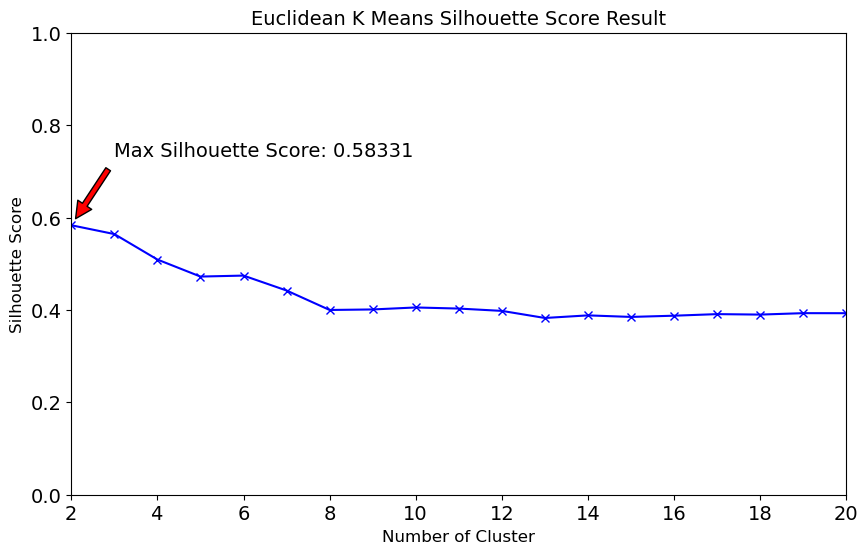

DBA K Means Silhouette Score Result
Max Silhouette Result: 0.61447
Cluster number: 2


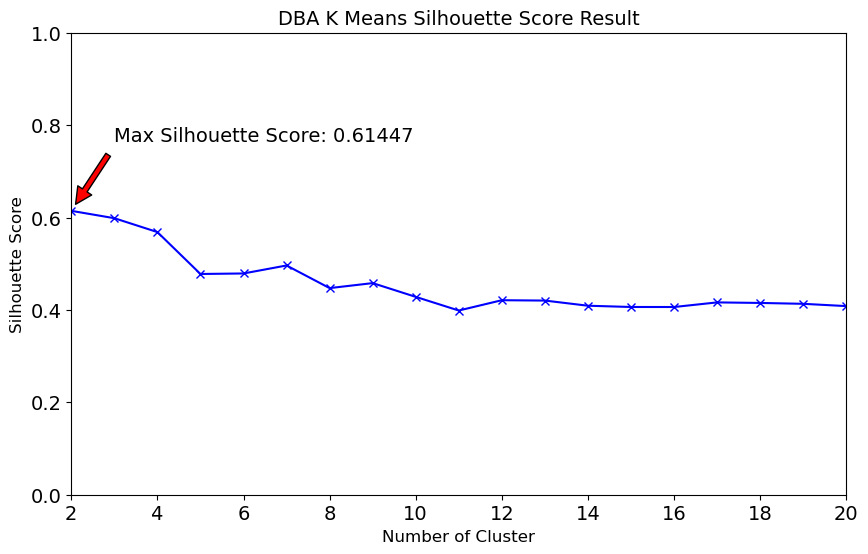

Soft DTW K Means Silhouette Score Result
Max Silhouette Result: 0.72079
Cluster number: 3


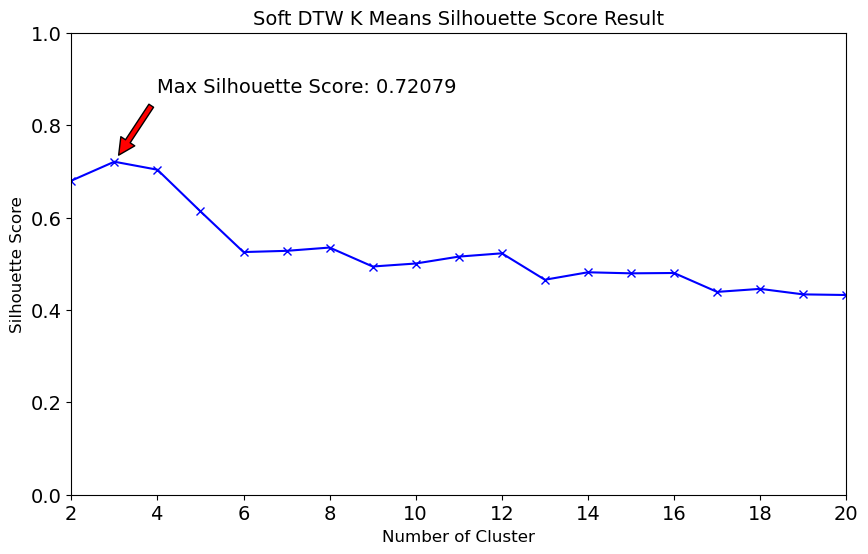

In [52]:
# CO2 Emissions (metrics ton per capital)

visualize_silhouette(
    df_sil_co2PerCapita['num_of_cluster'].tolist(), 
    df_sil_co2PerCapita['co2PerCapita-euclidean'].tolist(), 
    "Euclidean K Means Silhouette Score Result"
)
visualize_silhouette(
    df_sil_co2PerCapita['num_of_cluster'].tolist(), 
    df_sil_co2PerCapita['co2PerCapita-dba'].tolist(),
    "DBA K Means Silhouette Score Result"
)
visualize_silhouette(
    df_sil_co2PerCapita['num_of_cluster'].tolist(), 
    df_sil_co2PerCapita['co2PerCapita-softdtw'].tolist(), 
    "Soft DTW K Means Silhouette Score Result"
)

Euclidean K Means Silhouette Score Result
Max Silhouette Result: 0.82779
Cluster number: 2


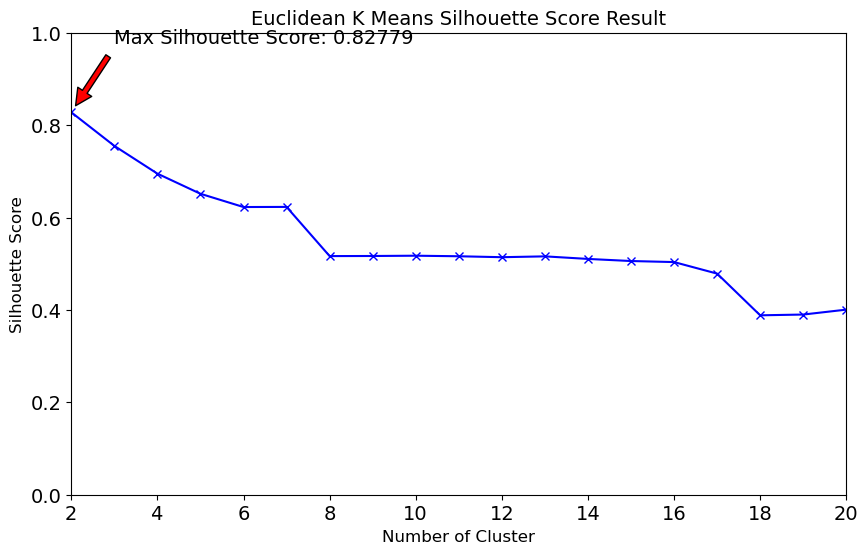

DBA K Means Silhouette Score Result
Max Silhouette Result: 0.83101
Cluster number: 2


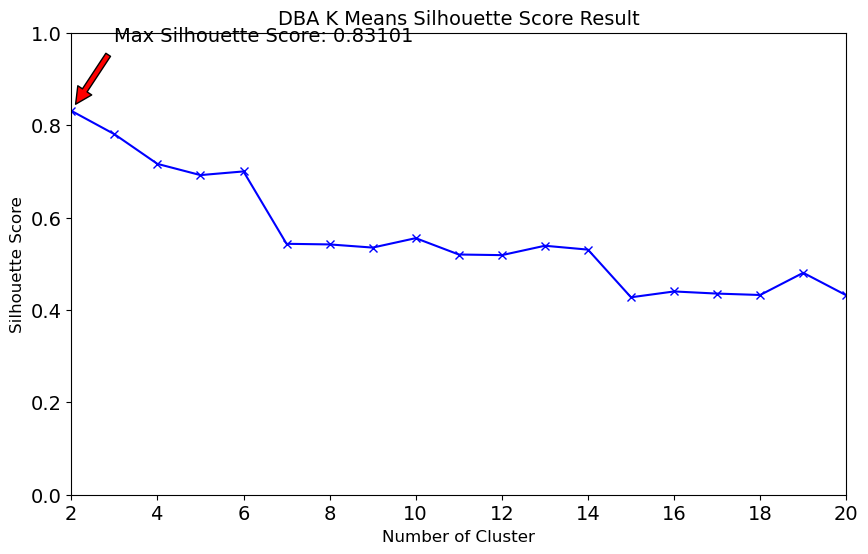

Soft DTW K Means Silhouette Score Result
Max Silhouette Result: 0.92097
Cluster number: 2


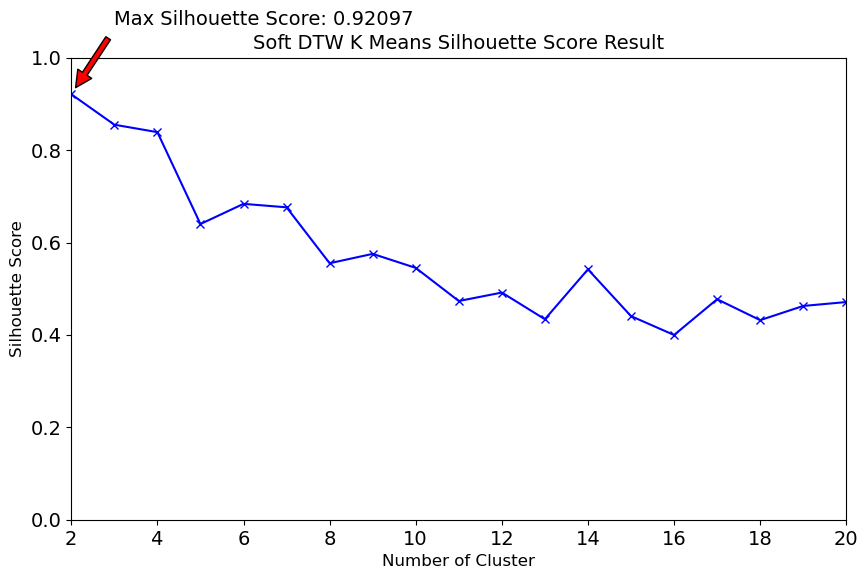

In [53]:
# Total Greenhouse Gas

visualize_silhouette(
    df_sil_totalGHG['num_of_cluster'].tolist(), 
    df_sil_totalGHG['totalGHG-euclidean'].tolist(), 
    "Euclidean K Means Silhouette Score Result"
)
visualize_silhouette(
    df_sil_totalGHG['num_of_cluster'].tolist(), 
    df_sil_totalGHG['totalGHG-dba'].tolist(),
    "DBA K Means Silhouette Score Result"
)
visualize_silhouette(
    df_sil_totalGHG['num_of_cluster'].tolist(), 
    df_sil_totalGHG['totalGHG-softdtw'].tolist(), 
    "Soft DTW K Means Silhouette Score Result"
)

In [54]:
# Final algorithm = Soft DTW
final_n_cluster = 3

In [55]:
def mergeClusterNames(y_pred, df_index, indexName):
    clusters = pd.Series(data=y_pred, index=df_index)
    df_cluster = clusters.to_frame()
    df_cluster.reset_index(drop=False, inplace=True)
    df_cluster.columns = [indexName, 'cluster']
    return df_cluster

# use this get cluster instead of directly filter it. 
# Because the graph displayed need to be -1 to get correct cluster name 
def getSingleCluster(df_cluster, n):
    # cluster 1 in the chart represent cluster 0 in the data.
    return df_cluster[df_cluster['cluster'] == n-1]

Soft-DTW k-means
0.716 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 0.276 --> 
Soft-DTW k-means Chart


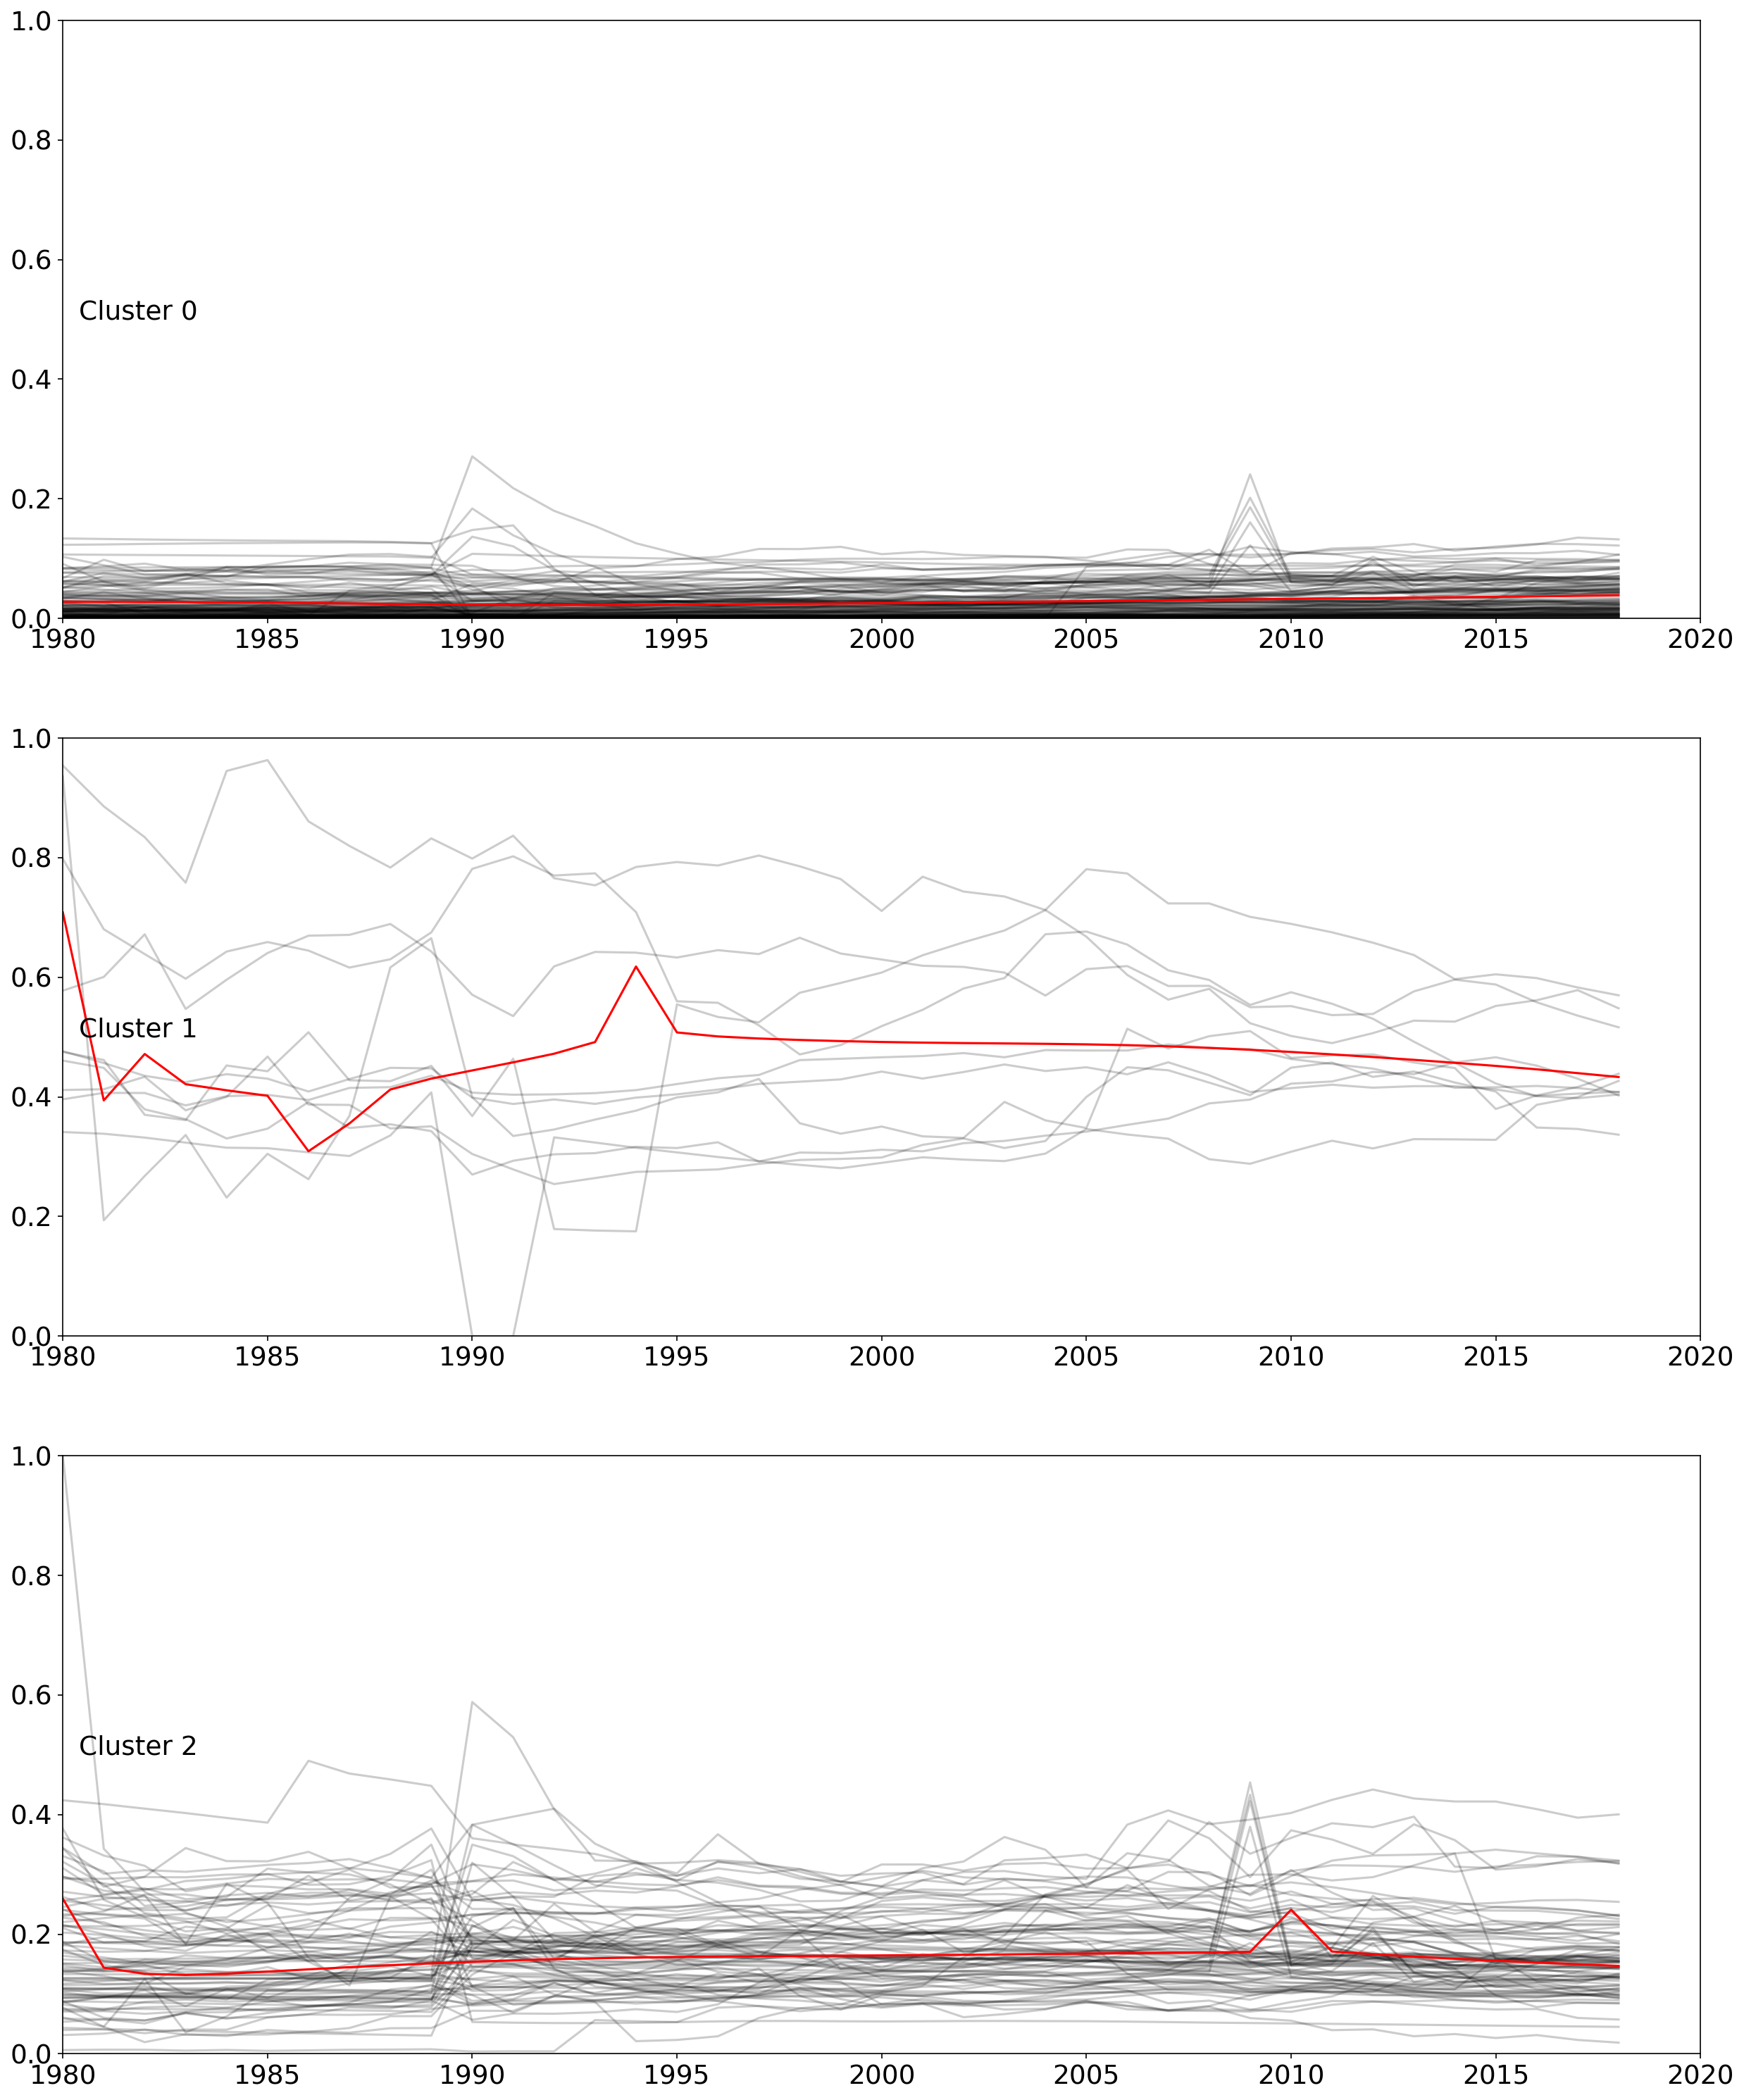

In [56]:
# co2 emissions per capita

mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.figsize"] = (20,25) #change figure size, (x, y)
y_pred_X_co2_emissions_per_capita, cluster_centers_co2_emissions_per_capita = softDTWKmeans(
    final_n_cluster, 
    seed, 
    X_train_co2_emissions_per_capita
)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.178 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.075 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.062 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.053 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.050 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.047 --> 0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Init 2


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.117 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.070 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.056 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


0.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


0.047 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.047 --> 


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


DBA k-means Chart


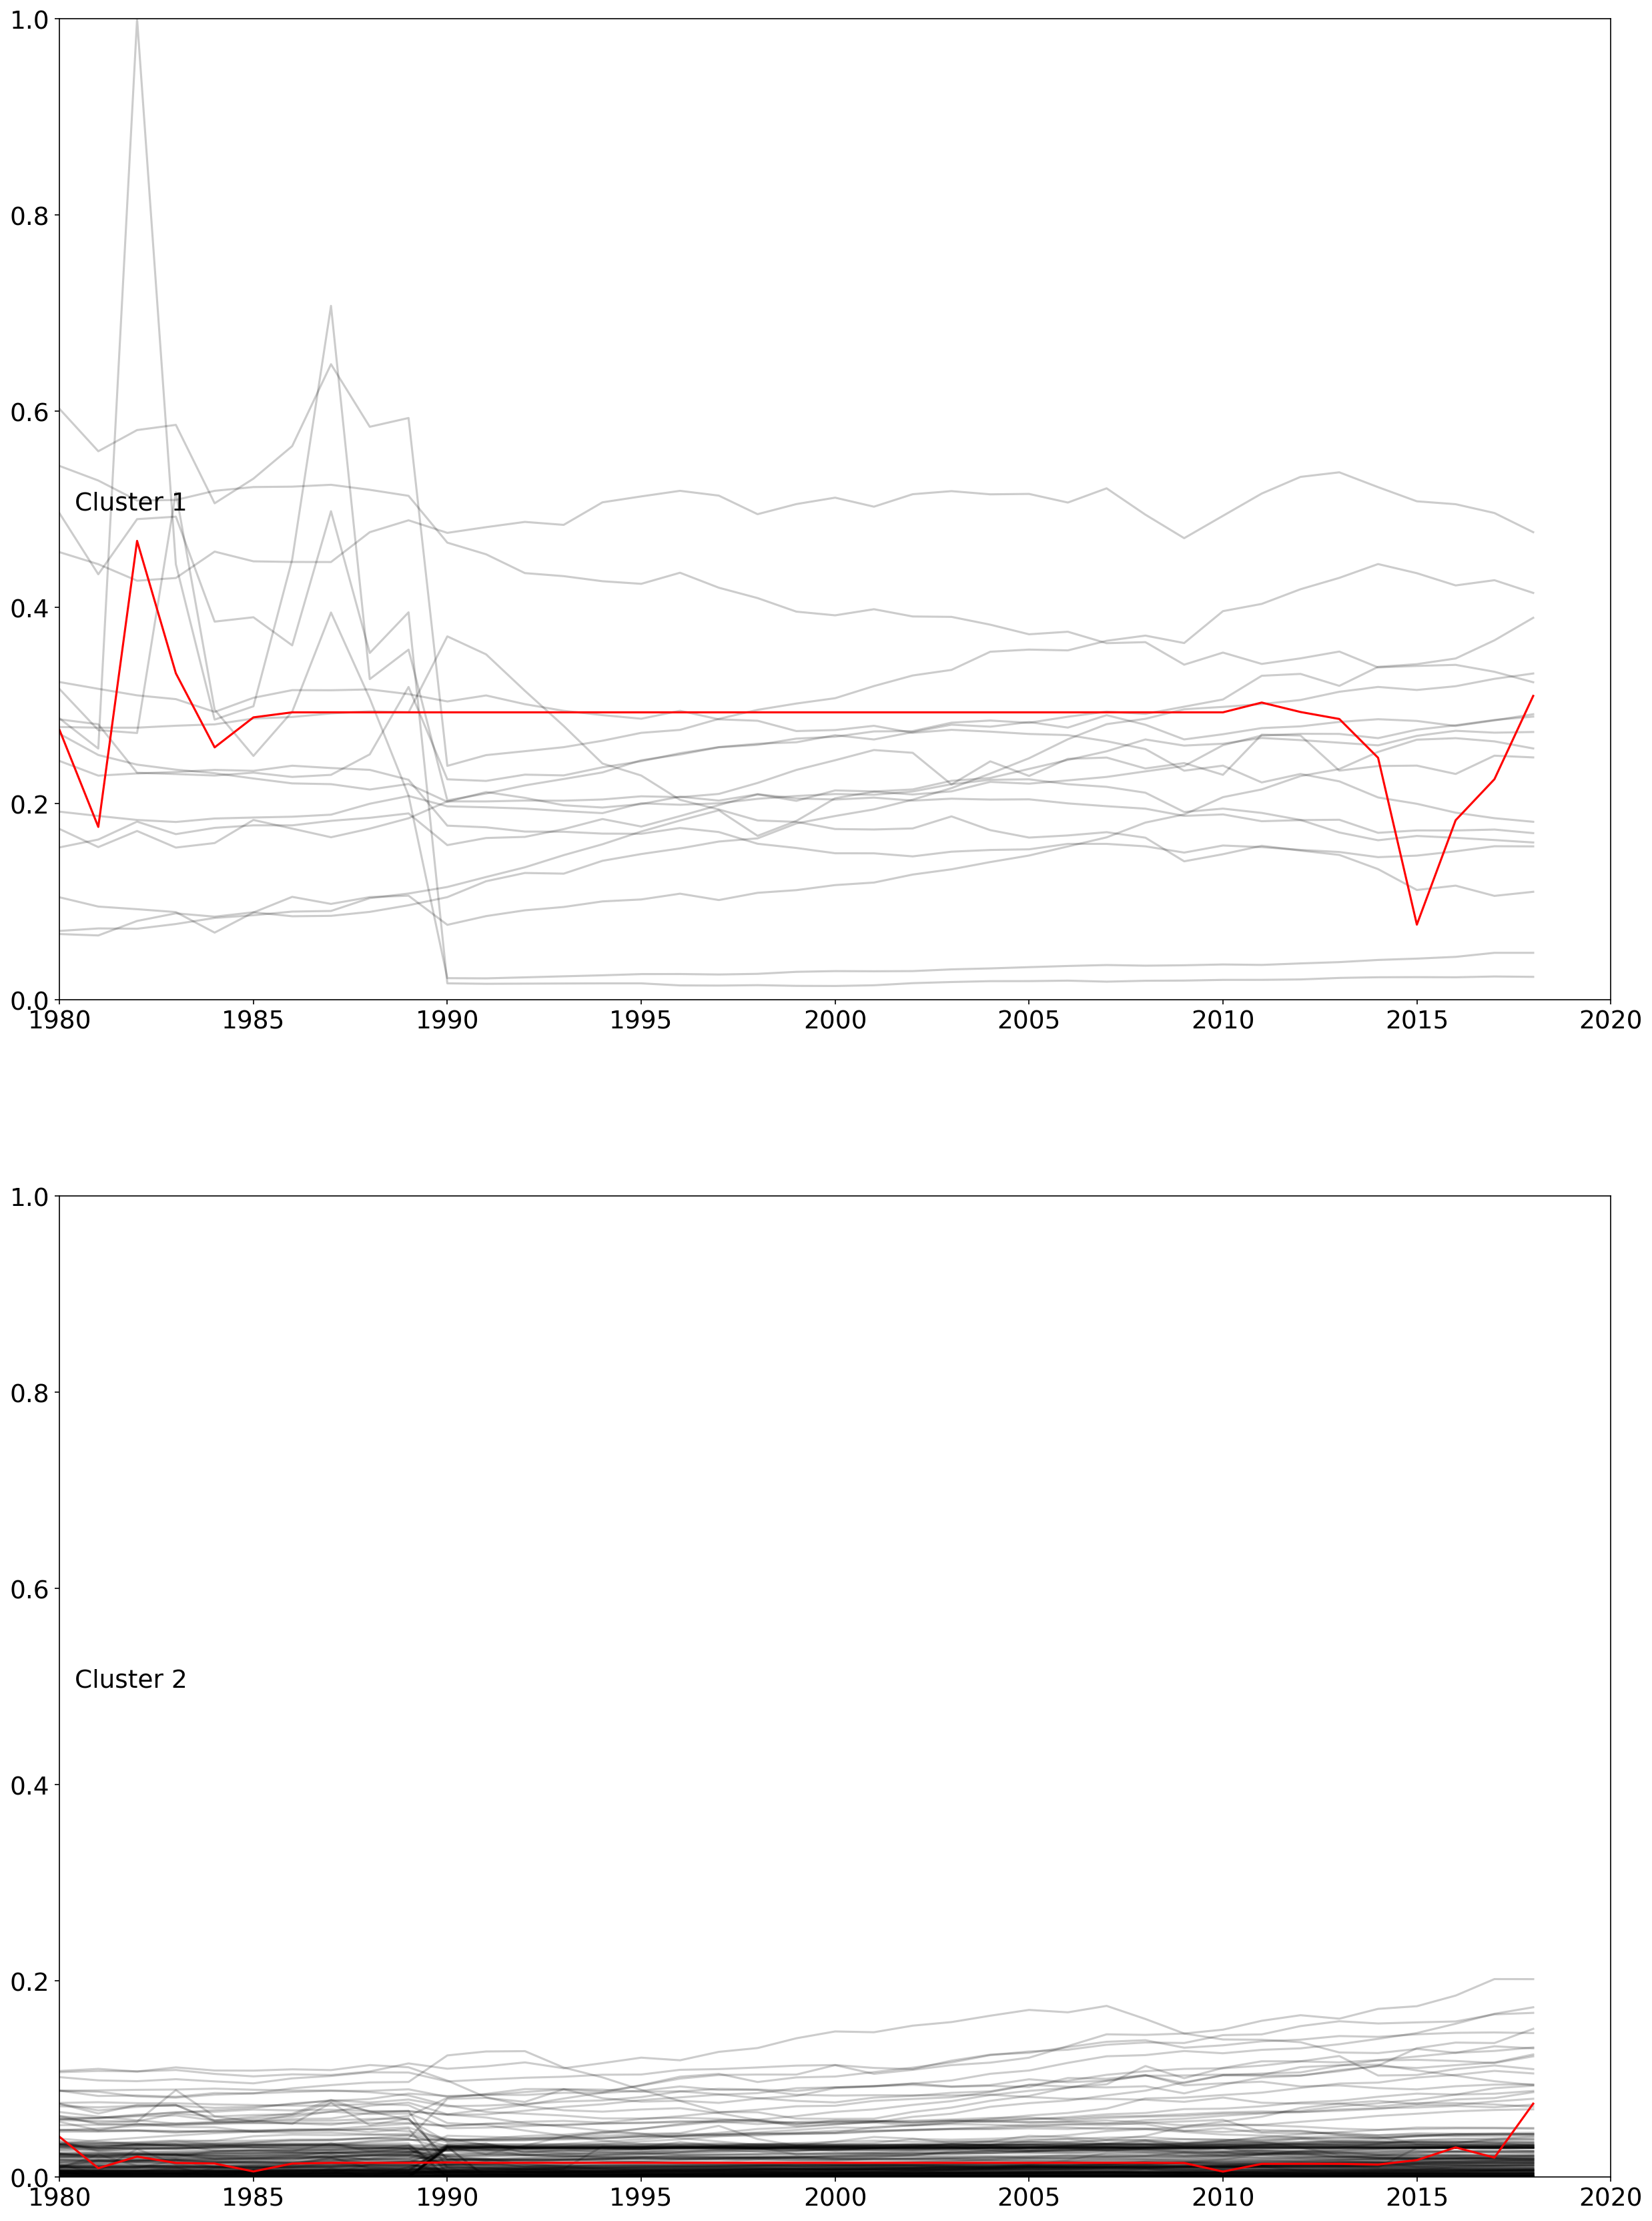

In [58]:
# total greenhouse gasses

mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.figsize"] = (20,28) #change figure size, (x, y)
y_pred_X_total_ghg, cluster_centers_total_ghg = dbaKMeans(
    2, 
    seed, 
    X_train_total_ghg
)

In [ ]:
# Archived

# co2 emissions
# y_pred_X_co2_emissions, cluster_centers_co2_emissions = softDTWKmeans(
#     final_n_cluster, 
#     seed, 
#     X_train_co2_emissions
# )

# Urban Population
# y_pred_X_urban_population = dbaKMeans(8, seed, X_train_urban_population)

# Population Growth
# y_pred_X_population_growth = dbaKMeans(5, seed, X_train_population_growth)

# other greenhouse gasses
# y_pred_X_other_ghg = dbaKMeans(10, seed, X_train_other_ghg)

# Methane Emissions
# y_pred_X_methane_emissions = dbaKMeans(5, seed, X_train_methane_emissions)

# co2 intensity
# y_pred_X_co2_intensity = dbaKMeans(5, seed, X_train_co2_intensity)

# Energy Use
# y_pred_X_energy_use = dbaKMeans(5, seed, X_train_energy_use)

## EDA for Clustering Results

In [62]:
# get y_pred result to merge with country name
# finally, will get dataframe of clustering result with country name

country_list = df_worldbank_imputed['Country Name'].unique().tolist()

cluster_result_co2_emissions_per_capita = mergeClusterNames(y_pred_X_co2_emissions_per_capita, country_list, feat_list[0])
cluster_result_total_ghg = mergeClusterNames(y_pred_X_total_ghg, country_list, feat_list[4])

In [ ]:
# Archived

# cluster_result_co2_emissions = mergeClusterNames(y_pred_X_co2_emissions, country_list, feat_list[1])
# cluster_result_urban_population = mergeClusterNames(y_pred_X_urban_population, country_list, feat_list[2])
# cluster_result_population_growth = mergeClusterNames(y_pred_X_population_growth, country_list, feat_list[3])
# cluster_result_other_ghg = mergeClusterNames(y_pred_X_other_ghg, country_list, feat_list[5])
# cluster_result_methane_emissions = mergeClusterNames(y_pred_X_methane_emissions, country_list, feat_list[6])
# cluster_result_co2_intensity = mergeClusterNames(y_pred_X_co2_intensity, country_list, feat_list[7])
# cluster_result_energy_use = mergeClusterNames(y_pred_X_energy_use, country_list, feat_list[8])

### Visualization

In [63]:
# input needed
# 
# df_raw_data : input the df_worldbank_imputed (data used as train set)
# df_cluster : the cluster result (`cluster_result_<indicatorName>`)
# cluster_number : follow graph's cluster number. No zero, 0

def get_df_viz(df_raw_data, df_cluster, clusterNumber):
    
    # prepare to filter data
    indicator_name = df_cluster.columns.tolist()[0]
    clusterNumber = clusterNumber - 1 # adjust number based on "graph" 
    cluster_country_name = df_cluster[df_cluster['cluster']==(clusterNumber)][indicator_name]
    cluster_country_name = cluster_country_name.unique().tolist()
    columnToKeep = ['Country Name', 'Year'] + [indicator_name]
    df_viz = df_raw_data.copy()
    
    print("INDICATOR NAME: " + indicator_name)
    print("ACTUAL CLUSTER: " + str(clusterNumber))
    print("NUMBER OF COUNTRY: " + str(len(cluster_country_name)))
    print("COUNTRY LIST: ")
    print(str(cluster_country_name))
    
    # selection
    df_viz = df_viz[columnToKeep]
    df_viz = df_viz[df_viz['Country Name'].isin(cluster_country_name)]
    df_viz.reset_index(inplace=True)
    return df_viz

In [ ]:
#
# ****************
# *** Archived ***
# ****************
#

# Clusters that require more attention

# co2 emissions per capital - cluster 7
# their trends is going upward


# co2 emissions - cluster 2, 3, 5, 6, 7, 8, 10
# urban population - cluster 
# population growth - cluster 
# total ghg - cluster
# other ghg - cluster
# co2 intensity - cluster 
# methane_emissions - cluster 
# energy use - cluster 

In [64]:
for i in range(final_n_cluster):
    fig = px.line(get_df_viz(df_raw_worldbank_transposed, cluster_result_co2_emissions_per_capita, i+1), 
                  x="Year", 
                  y=feat_list[0], 
                  color='Country Name')
    fig.show()

INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 0
NUMBER OF COUNTRY: 110
COUNTRY LIST: 
['Afghanistan', 'Angola', 'Albania', 'Armenia', 'Burundi', 'Benin', 'Burkina Faso', 'Bangladesh', 'Belize', 'Bolivia', 'Brazil', 'Bhutan', 'Botswana', 'Chile', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Djibouti', 'Dominica', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Eritrea', 'Ethiopia', 'Fiji', 'Micronesia, Fed. Sts.', 'Georgia', 'Ghana', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Indonesia', 'Jamaica', 'Jordan', 'Kenya', 'Kyrgyz Republic', 'Cambodia', 'Kiribati', 'Lao PDR', 'Lebanon', 'Liberia', 'St. Lucia', 'Sri Lanka', 'Lesotho', 'Morocco', 'Moldova', 'Madagascar', 'Maldives', 'Marshall Islands', 'Mali', 'Myanmar', 'Montenegro', 'Mozambique', 'Mauritania', 'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria', 'Nicar

INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 1
NUMBER OF COUNTRY: 10
COUNTRY LIST: 
['United Arab Emirates', 'Australia', 'Bahrain', 'Brunei Darussalam', 'Canada', 'Kuwait', 'Luxembourg', 'Palau', 'Saudi Arabia', 'Trinidad and Tobago']


INDICATOR NAME: CO2 emissions (metric tons per capita)
ACTUAL CLUSTER: 2
NUMBER OF COUNTRY: 80
COUNTRY LIST: 
['Andorra', 'Argentina', 'American Samoa', 'Antigua and Barbuda', 'Austria', 'Azerbaijan', 'Belgium', 'Bulgaria', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Bermuda', 'Barbados', 'Switzerland', 'Caribbean small states', 'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'Faroe Islands', 'Gabon', 'United Kingdom', 'Gibraltar', 'Equatorial Guinea', 'Greece', 'Greenland', 'Guam', 'Hong Kong SAR, China', 'Croatia', 'Hungary', 'Ireland', 'Iran, Islamic Rep.', 'Iraq', 'Iceland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'St. Kitts and Nevis', 'Korea, Rep.', 'Libya', 'Liechtenstein', 'Lithuania', 'Latvia', 'Macao SAR, China', 'Mexico', 'North Macedonia', 'Malta', 'Mongolia', 'Malaysia', 'New Caledonia', 'Netherlands', 'Norway', 'Nauru', 'New Zealand', 'Oman', 'Poland', 'Puerto Rico', "Korea, Dem. People's Rep.", 'Por

In [65]:
for i in range(final_n_cluster):
    fig = px.line(get_df_viz(df_raw_worldbank_transposed, cluster_result_total_ghg, i+1), 
                  x="Year",
                  y=feat_list[4], 
                  color='Country Name',
                 markers=False)
    fig.show()

INDICATOR NAME: Total greenhouse gas emissions (kt of CO2 equivalent)
ACTUAL CLUSTER: 0
NUMBER OF COUNTRY: 17
COUNTRY LIST: 
['Australia', 'Brazil', 'Canada', 'Congo, Dem. Rep.', 'Germany', 'France', 'United Kingdom', 'Indonesia', 'Iran, Islamic Rep.', 'Italy', 'Japan', 'Korea, Rep.', 'Mexico', 'Myanmar', 'Poland', 'Saudi Arabia', 'Ukraine']


INDICATOR NAME: Total greenhouse gas emissions (kt of CO2 equivalent)
ACTUAL CLUSTER: 1
NUMBER OF COUNTRY: 183
COUNTRY LIST: 
['Afghanistan', 'Angola', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antigua and Barbuda', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana', 'Switzerland', 'Chile', "Cote d'Ivoire", 'Cameroon', 'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Caribbean small states', 'Cuba', 'Cayman Islands', 'Cyprus', 'Czech Republic', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Eritrea', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'Faroe Islands', 'Micronesia, Fed. Sts.', 'Gabon', 'Georgia', 'Ghana', 'Gibraltar', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'E

INDICATOR NAME: Total greenhouse gas emissions (kt of CO2 equivalent)
ACTUAL CLUSTER: 2
NUMBER OF COUNTRY: 0
COUNTRY LIST: 
[]


In [66]:
# Output results

cluster_result_co2_emissions_per_capita.set_axis(['Country Name', feat_list[0]], axis=1, inplace=True)
cluster_result_total_ghg.set_axis(['Country Name', feat_list[4]], axis=1, inplace=True)

In [67]:
cluster_result_co2_emissions_per_capita.set_index('Country Name')
cluster_result_total_ghg.set_index('Country Name')

clustering_result = cluster_result_co2_emissions_per_capita.merge(cluster_result_total_ghg, on='Country Name')
clustering_result

Country Name  CO2 emissions (metric tons per capita)  \
0             Afghanistan                                       0   
1                  Angola                                       0   
2                 Albania                                       0   
3                 Andorra                                       2   
4    United Arab Emirates                                       1   
..                    ...                                     ...   
195               Vanuatu                                       0   
196                 Samoa                                       0   
197           Yemen, Rep.                                       0   
198                Zambia                                       0   
199              Zimbabwe                                       0   

     Total greenhouse gas emissions (kt of CO2 equivalent)  
0                                                    1      
1                                                    1      
2                                                    1      
3                                                    1      
4                                                    1      
..                                                 ...      
195                                                  1      
196                                                  1      
197                                                  1      
198                                                  1      
199                                                  1      

[200 rows x 3 columns]

In [83]:
def make_df_cluster_centers(cluster_centers_result, col_name=""):
    df_cluster_centers = pd.DataFrame(
        {
            (col_name+' cluster1'): cluster_centers_result[0].flatten(), 
            (col_name+' cluster2'): cluster_centers_result[1].flatten(),
            (col_name+' cluster3'): cluster_centers_result[2].flatten()
        }
    )
    return df_cluster_centers

df_cluster_centers_co2_emissions_per_capita = make_df_cluster_centers(cluster_centers_co2_emissions_per_capita, "co2PerCapita")
df_cluster_centers_co2_emissions_per_capita.tail()

co2PerCapita cluster1  co2PerCapita cluster2  co2PerCapita cluster3
34               0.035408               0.457010               0.159008
35               0.036084               0.451814               0.155742
36               0.036866               0.446109               0.152719
37               0.037788               0.439745               0.149896
38               0.038818               0.433231               0.146997

In [84]:
def make_df_cluster_centers_2(cluster_centers_result, col_name=""):
    df_cluster_centers = pd.DataFrame(
        {
            (col_name+' cluster1'): cluster_centers_result[0].flatten(), 
            (col_name+' cluster2'): cluster_centers_result[1].flatten()
        }
    )
    return df_cluster_centers

df_cluster_centers_total_GHG = make_df_cluster_centers_2(cluster_centers_total_ghg, "totalGHG")
df_cluster_centers_total_GHG.tail()

totalGHG cluster1  totalGHG cluster2
34           0.246888           0.012947
35           0.076838           0.017442
36           0.183231           0.030398
37           0.225044           0.020050
38           0.309995           0.075019

In [87]:
clustering_centers_result = pd.concat(
    [df_cluster_centers_co2_emissions_per_capita, df_cluster_centers_total_GHG], 
    axis = 1
)

clustering_centers_result.tail()

co2PerCapita cluster1  co2PerCapita cluster2  co2PerCapita cluster3  \
34               0.035408               0.457010               0.159008   
35               0.036084               0.451814               0.155742   
36               0.036866               0.446109               0.152719   
37               0.037788               0.439745               0.149896   
38               0.038818               0.433231               0.146997   

    totalGHG cluster1  totalGHG cluster2  
34           0.246888           0.012947  
35           0.076838           0.017442  
36           0.183231           0.030398  
37           0.225044           0.020050  
38           0.309995           0.075019

In [103]:
clustering_centers_result['year'] = years_range[:-2]
col_name="year"
first_col = clustering_centers_result.pop(col_name)
clustering_centers_result.insert(0, col_name, first_col)
clustering_centers_result.tail()

year  co2PerCapita cluster1  co2PerCapita cluster2  co2PerCapita cluster3  \
34  2014               0.035408               0.457010               0.159008   
35  2015               0.036084               0.451814               0.155742   
36  2016               0.036866               0.446109               0.152719   
37  2017               0.037788               0.439745               0.149896   
38  2018               0.038818               0.433231               0.146997   

    totalGHG cluster1  totalGHG cluster2  
34           0.246888           0.012947  
35           0.076838           0.017442  
36           0.183231           0.030398  
37           0.225044           0.020050  
38           0.309995           0.075019

In [105]:
clustering_result.to_csv("./output/clustering/clustering_result.csv", index=False)
clustering_centers_result.to_csv("./output/clustering/clustering_result_centers.csv", index=False)

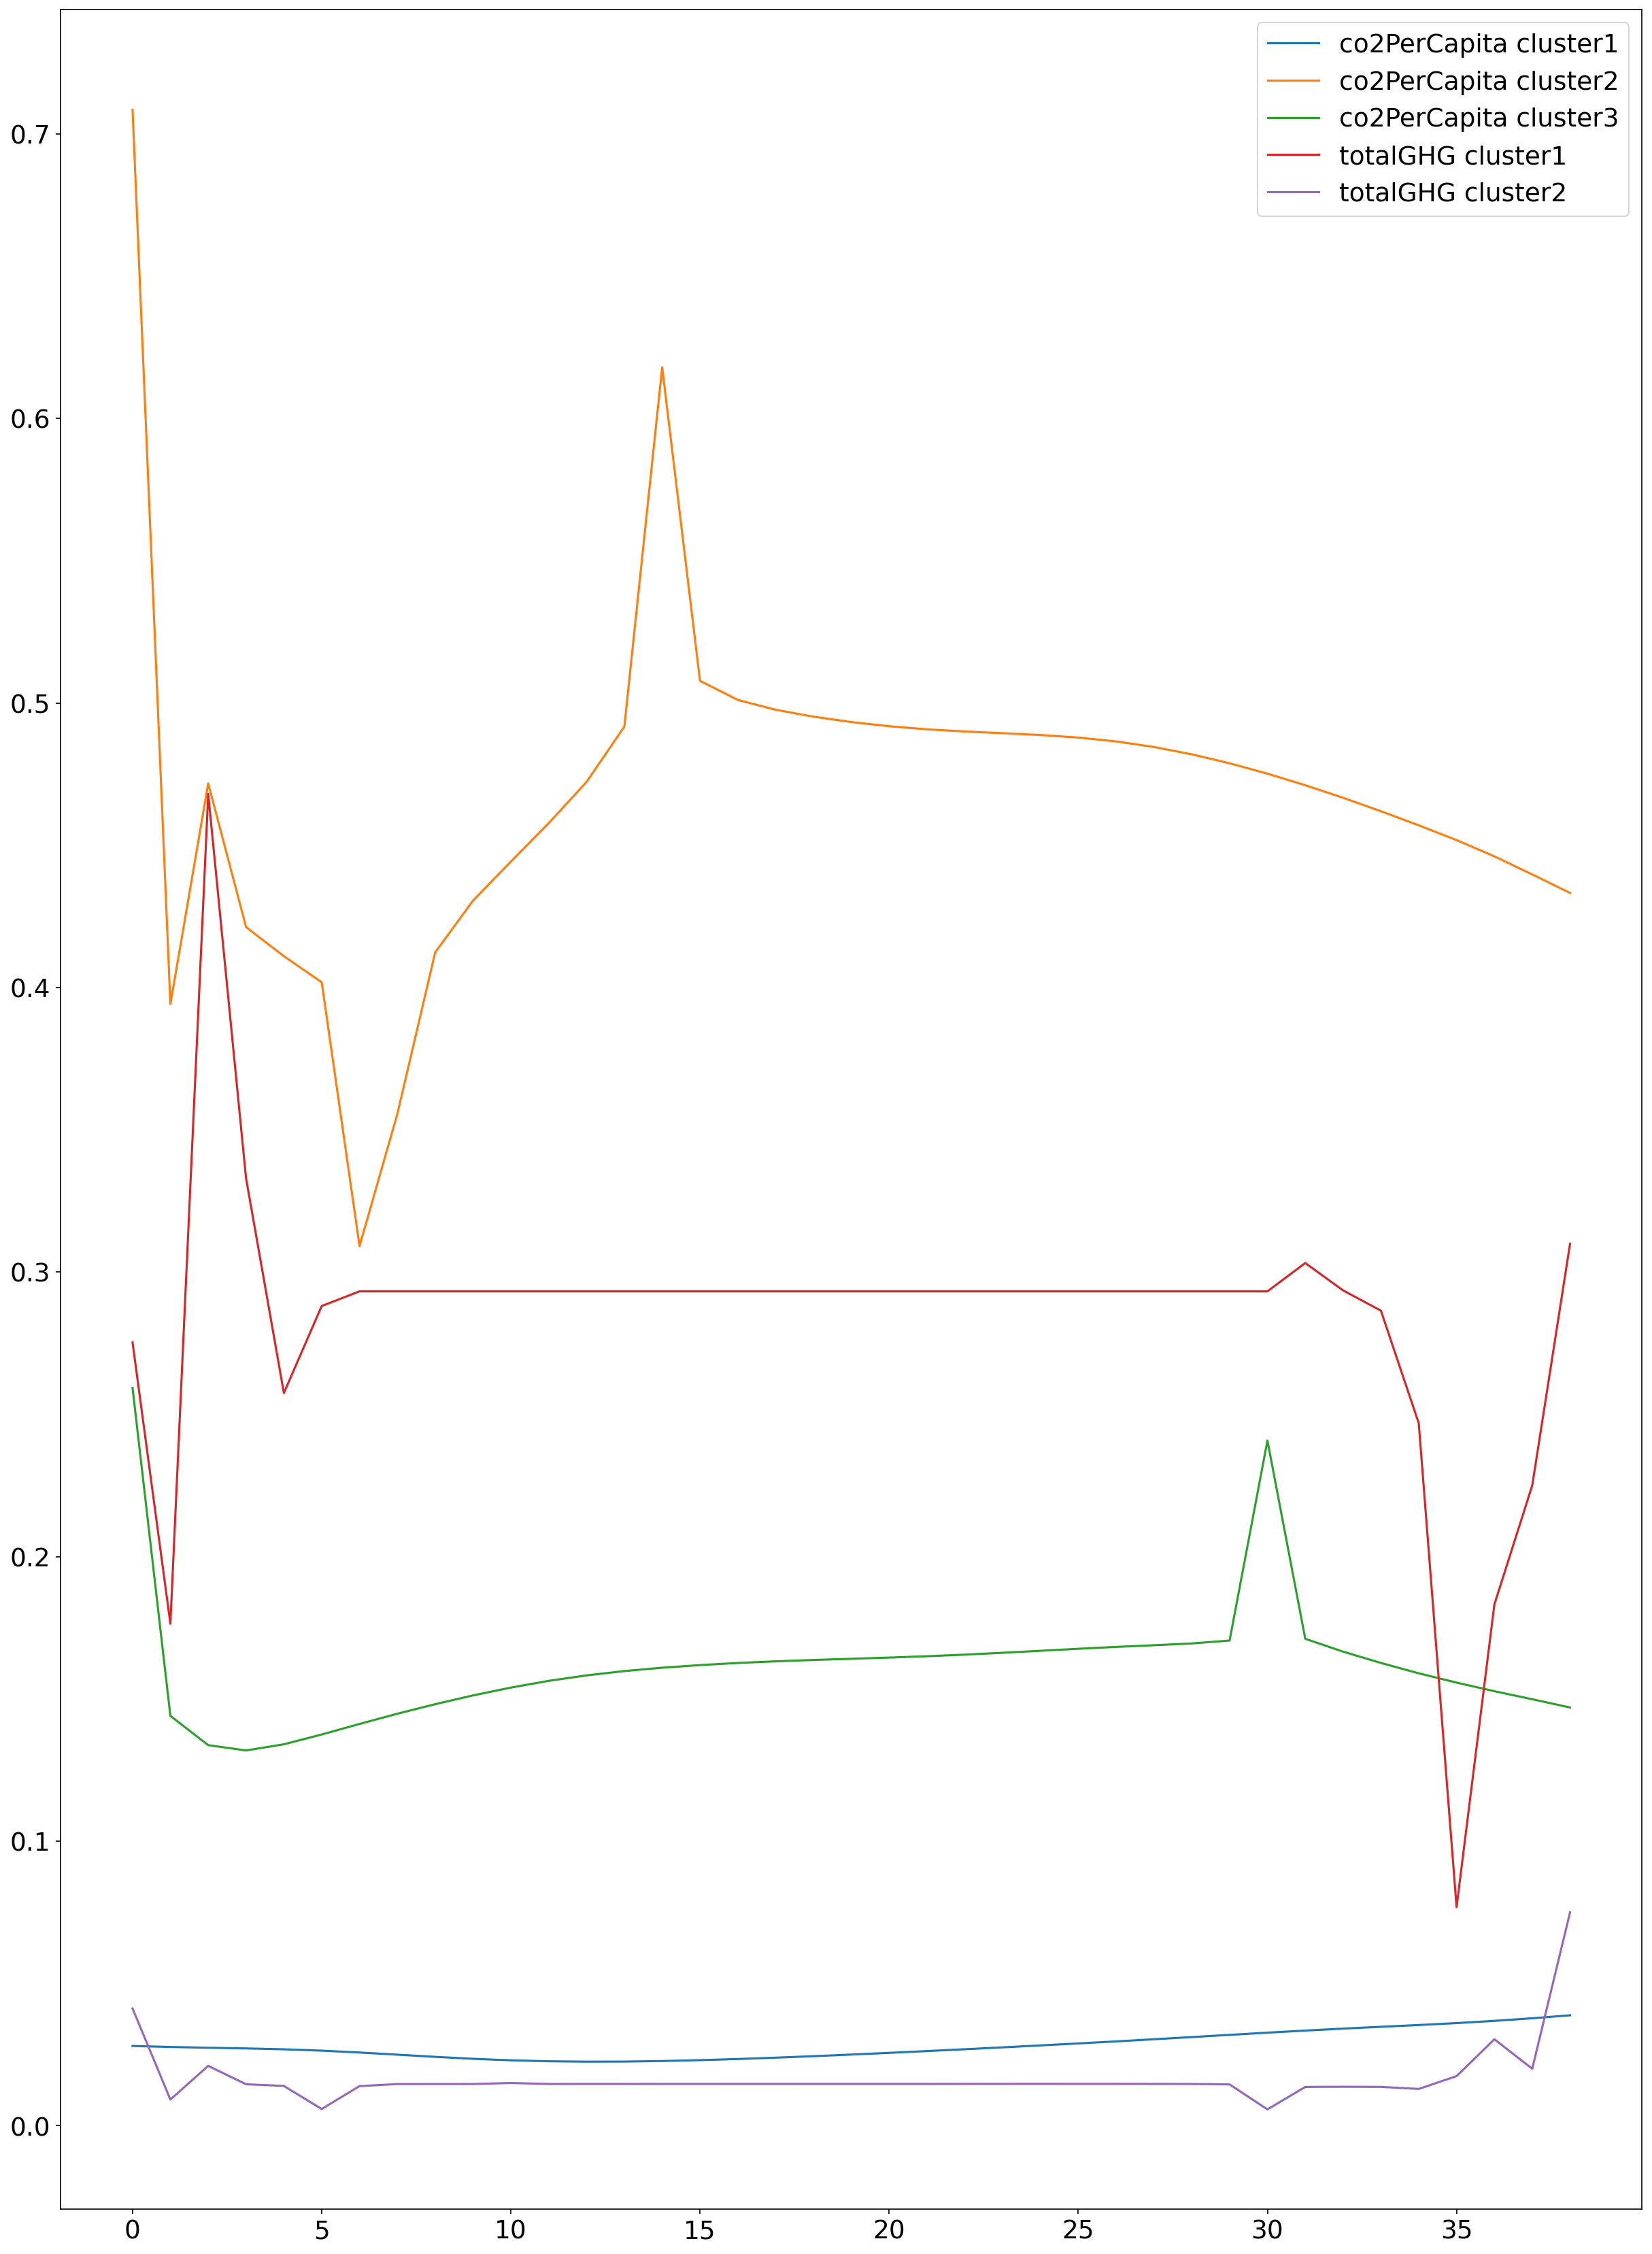

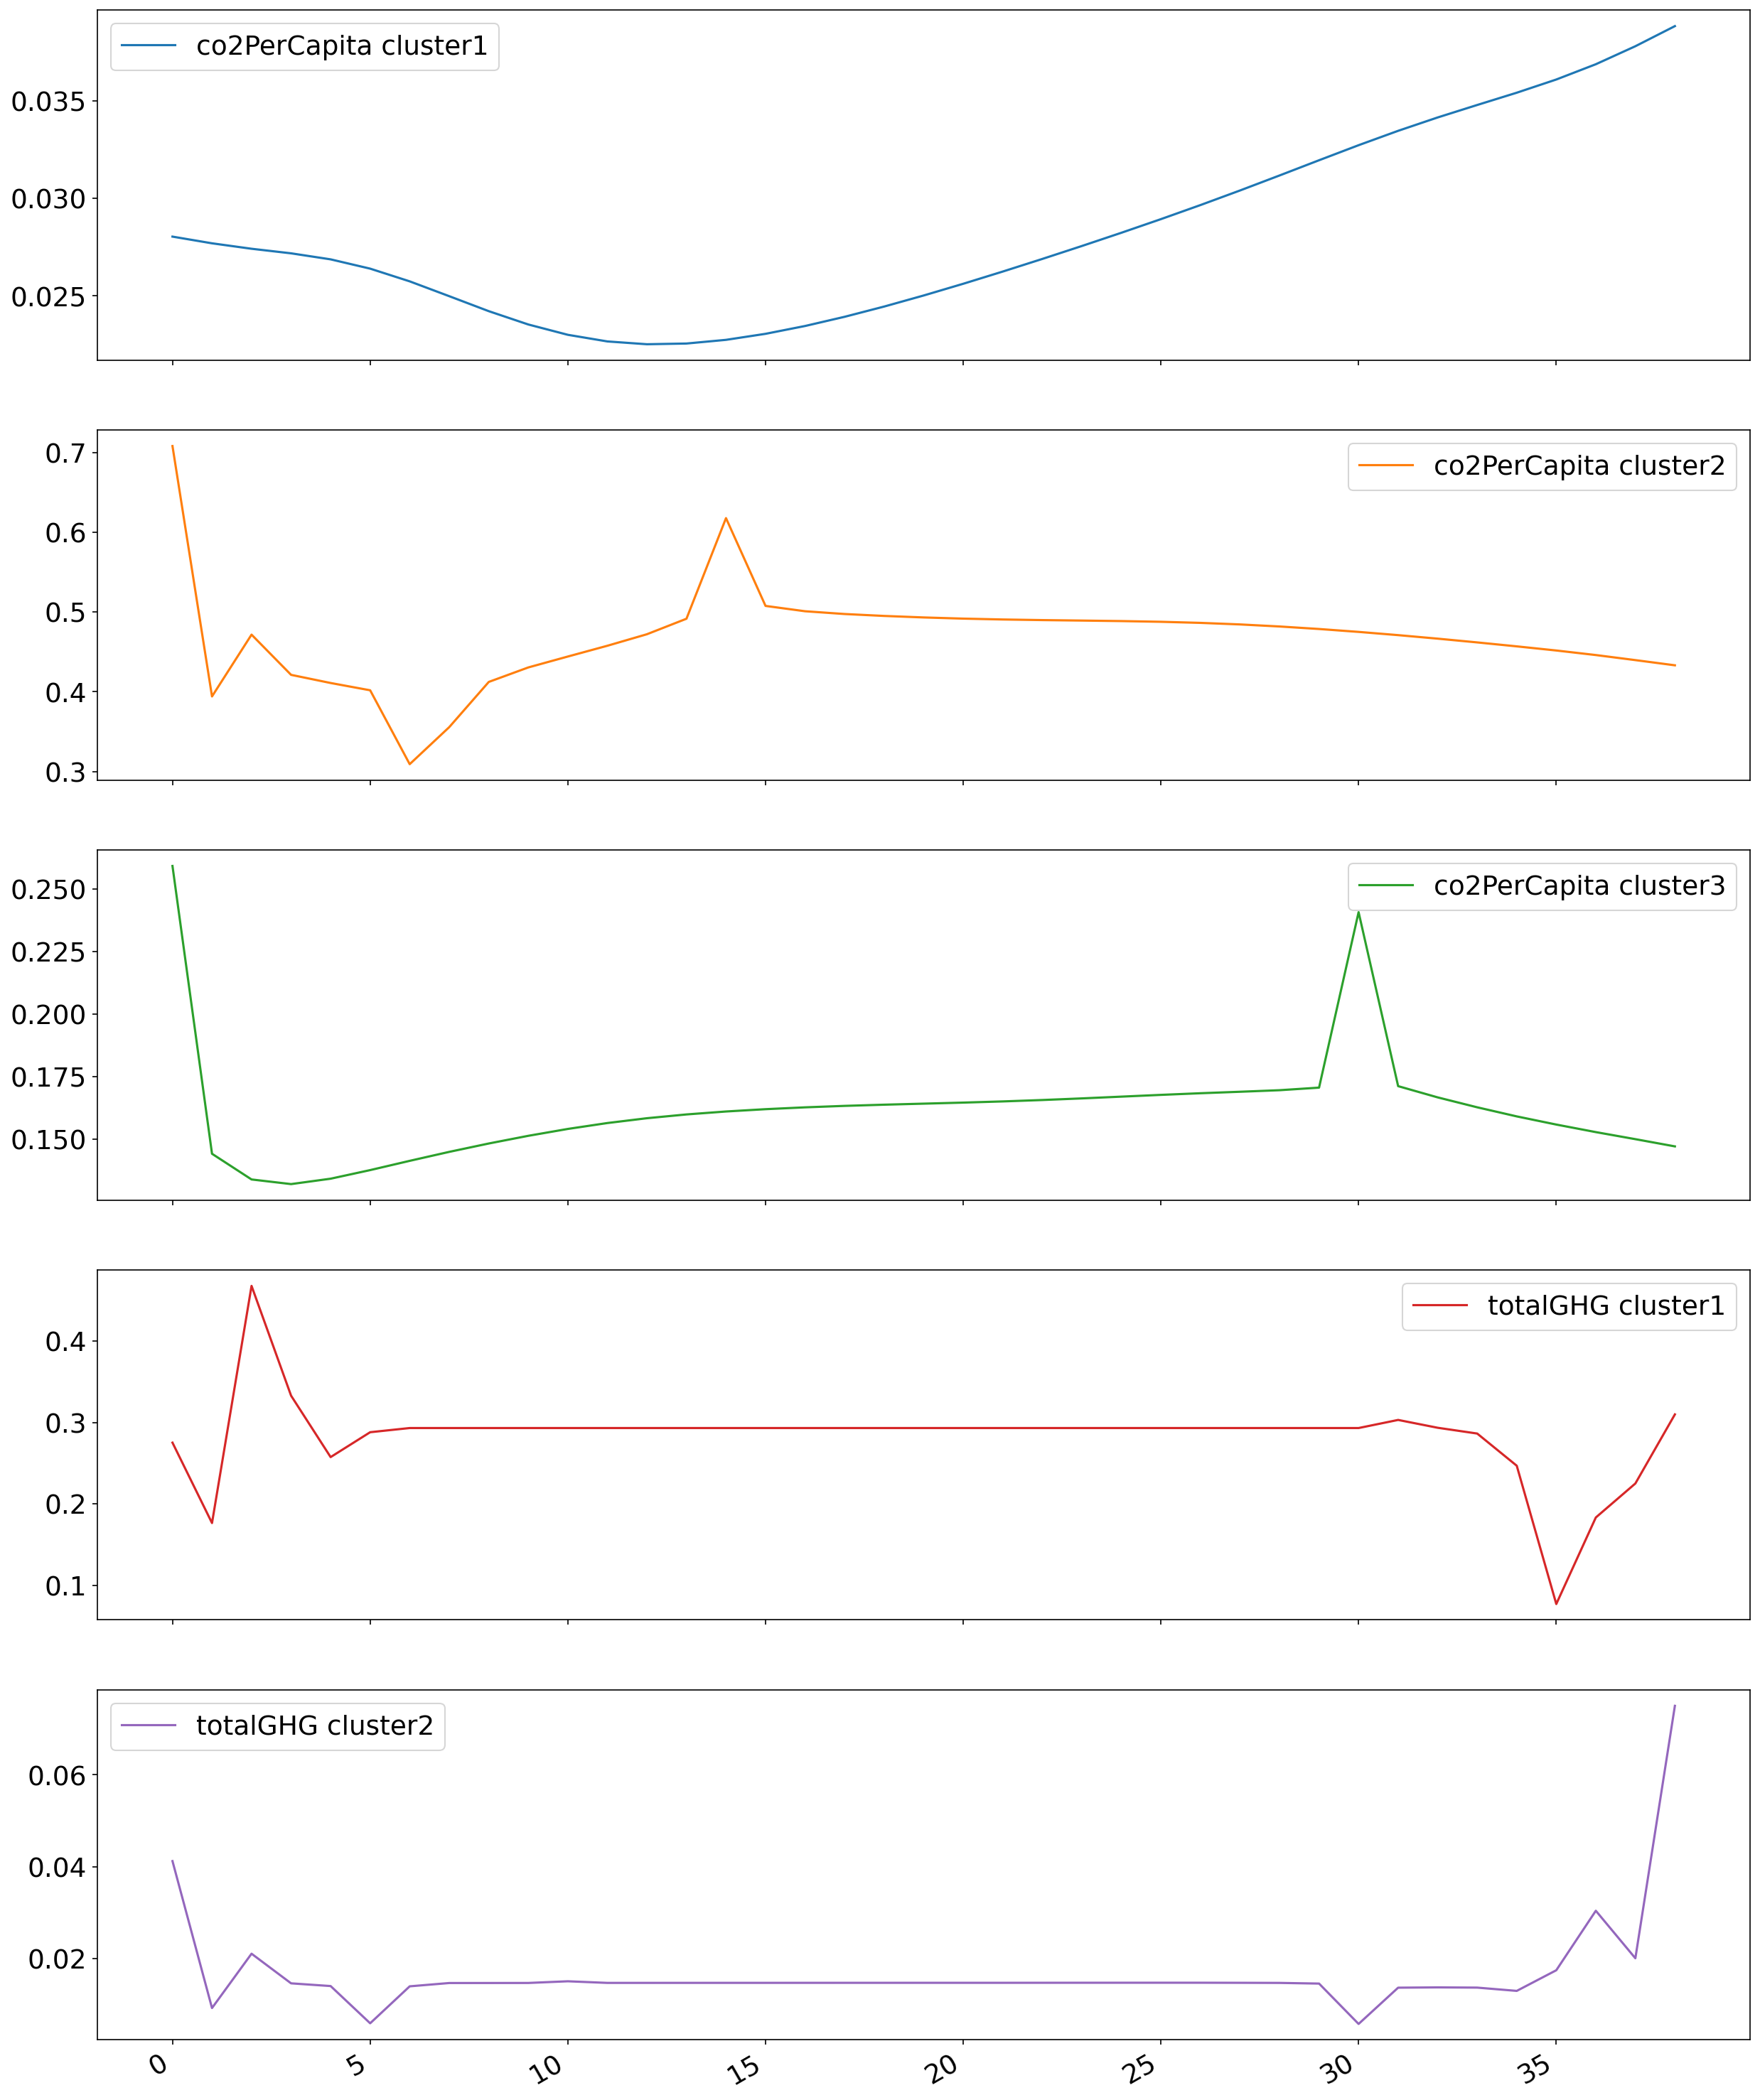

In [95]:
clustering_centers_result.plot()
clustering_centers_result.plot.line(subplots=True)
plt.show()